# Cross species conservation - Endocrine cells

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import seaborn as sns
import xlsxwriter
from matplotlib import rcParams
import gseapy as gp
import itertools
from scipy.stats.stats import pearsonr, spearmanr

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.8 umap==0.4.1 numpy==1.21.2 scipy==1.5.4 pandas==1.3.5 scikit-learn==0.22 statsmodels==0.13.2 python-igraph==0.8.0 louvain==0.7.0 leidenalg==0.7.0


## Endocrine cells

### Load data

In [4]:
human = sc.read('../data/adata_human_endo.h5ad')
pig = sc.read('../data/adata_pig_endo.h5ad')
mouse = sc.read('../data/mouse_all.h5ad')

In [ ]:
# load from GEO h5ad-files
# # human
# human = sc.read('../data/human_processed.h5ad')
# del human.raw
# human = human[:, ~human_endo.var.feature_is_filtered].copy()

# # pig
# pig = sc.read('../data/pig_processed.h5ad')
# del pig.raw
# pig = pig[:, ~pig.var.feature_is_filtered].copy()

In [ ]:
conv = pd.read_csv('./BED_mapping_genes.csv')

In [23]:
conv

Unnamed: 0             pig_ens        human_ens mouse_symbol  \
0               0  ENSSSCG00000018065  ENSG00000198888       mt-Nd1   
1               1  ENSSSCG00000018069  ENSG00000198763       mt-Nd2   
2               2  ENSSSCG00000018075  ENSG00000198804       mt-Co1   
3               3  ENSSSCG00000018078  ENSG00000198712       mt-Co2   
4               4  ENSSSCG00000018080  ENSG00000228253      mt-Atp8   
...           ...                 ...              ...          ...   
12089       12089  ENSSSCG00000006893  ENSG00000137936        Bcar3   
12090       12090  ENSSSCG00000004300  ENSG00000111850        Smim8   
12091       12091  ENSSSCG00000004027  ENSG00000112541       Pde10a   
12092       12092  ENSSSCG00000016629  ENSG00000004866          St7   
12093       12093  ENSSSCG00000008383  ENSG00000173209        Ahsa2   

               pig_symbol  pig_mean human_symbol  human_mean  mouse_mean  
0                     ND1  1.713922       MT-ND1    4.329835    3.859940  
1                     ND2  1.489010       MT-ND2    4.759167    3.184796  
2                    COX1  4.302451       MT-CO1    5.027821    4.381054  
3                    COX2  4.226625       MT-CO2    4.755474    4.115138  
4                    ATP8  0.003994      MT-ATP8    0.111033    0.274089  
...                   ...       ...          ...         ...         ...  
12089               BCAR3  0.007951        BCAR3    0.059023    0.003854  
12090               SMIM8  0.068192        SMIM8    0.150541    0.239524  
12091              PDE10A  0.002703       PDE10A    0.020026    0.566537  
12092                 ST7  0.053978          ST7    0.109374    0.042823  
12093  ENSSSCG00000008383  0.053517        AHSA2    0.069564    0.081796  

[12094 rows x 9 columns]

In [6]:
conv = conv.loc[[gene in human.var_names for gene in conv['human_symbol']]]
conv = conv.loc[[gene in pig.var_names for gene in conv['pig_symbol']]]
conv = conv.loc[[gene in mouse.var_names for gene in conv['mouse_symbol']]]

### Explained variance by mappable genes

In [20]:
df_var = pd.DataFrame(index=['all cells', 'alpha', 'beta', 'delta', 'PP'], columns=['human', 'pig', 'mouse'])

In [21]:
# human
df = np.var(human.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['human_symbol'].tolist()].sum()
print(f'explained variance human - all cells: {var_sub/var_tot}')
df_var.loc['all cells', 'human'] = var_sub/var_tot

for group in human.obs.louvain_anno_broad.cat.categories:
    df = np.var(human[human.obs.louvain_anno_broad.isin([group])].copy().to_df(), axis=0)
    var_tot = df.sum()
    var_sub = df.loc[conv['human_symbol'].tolist()].sum()
    print(f'explained variance human - {group} cells: {var_sub/var_tot}')
    df_var.loc[group, 'human'] = var_sub/var_tot

explained variance human - all cells: 0.8690779805183411
explained variance human - alpha cells: 0.8735045790672302
explained variance human - beta cells: 0.8652795553207397
explained variance human - delta cells: 0.8672295808792114
explained variance human - PP cells: 0.8558482527732849


In [22]:
# pig
df = np.var(pig.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['pig_symbol'].tolist()].sum()
print(f'explained variance pig: {var_sub/var_tot}')
df_var.loc['all cells', 'pig'] = var_sub/var_tot

for group in pig.obs.louvain_anno_broad.cat.categories:
    df = np.var(pig[pig.obs.louvain_anno_broad.isin([group])].copy().to_df(), axis=0)
    var_tot = df.sum()
    var_sub = df.loc[conv['pig_symbol'].tolist()].sum()
    print(f'explained variance pig - {group} cells: {var_sub/var_tot}')
    df_var.loc[group, 'pig'] = var_sub/var_tot

explained variance pig: 0.9413137435913086
explained variance pig - alpha cells: 0.939766526222229
explained variance pig - beta cells: 0.942504346370697
explained variance pig - delta cells: 0.9400315284729004
explained variance pig - PP cells: 0.9409292936325073


In [24]:
# mouse
df = np.var(mouse.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['mouse_symbol'].tolist()].sum()
print(f'explained variance mouse: {var_sub/var_tot}')
df_var.loc['all cells', 'mouse'] = var_sub/var_tot

for group in mouse.obs.louvain_anno_broad.cat.categories:
    df = np.var(mouse[mouse.obs.louvain_anno_broad.isin([group])].copy().to_df(), axis=0)
    var_tot = df.sum()
    var_sub = df.loc[conv['mouse_symbol'].tolist()].sum()
    print(f'explained variance mouse - {group} cells: {var_sub/var_tot}')
    df_var.loc[group, 'mouse'] = var_sub/var_tot

explained variance mouse: 0.8877675533294678
explained variance mouse - alpha cells: 0.8893857002258301
explained variance mouse - beta cells: 0.8887761831283569
explained variance mouse - delta cells: 0.8880693912506104
explained variance mouse - PP cells: 0.8885635137557983


In [25]:
df_var

human       pig     mouse
all cells  0.869078  0.941314  0.887768
alpha      0.873505  0.939767  0.889386
beta        0.86528  0.942504  0.888776
delta       0.86723  0.940032  0.888069
PP         0.855848  0.940929  0.888564

In [26]:
df_var.mean(axis=1)

all cells    0.899386
alpha        0.900886
beta         0.898853
delta        0.898444
PP           0.895114
dtype: float64

### Subset data to mappable genes

In [8]:
human_comb_endo = human[:,conv['human_symbol'].tolist()].copy()

In [9]:
human_comb_endo.var_names

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4',
       ...
       'BACH1', 'FAM83H-AS1', 'FAM53C', 'GTPBP10', 'SUMF1', 'BCAR3', 'SMIM8',
       'PDE10A', 'ST7', 'AHSA2'],
      dtype='object', name='index', length=11665)

In [10]:
pig_comb_endo = pig[:,conv['pig_symbol'].tolist()].copy()
pig_comb_endo.var_names

Index(['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L',
       'ND4',
       ...
       'BACH1', 'IQANK1', 'FAM53C', 'ENSSSCG00000015305', 'SUMF1', 'BCAR3',
       'SMIM8', 'PDE10A', 'ST7', 'ENSSSCG00000008383'],
      dtype='object', name='index', length=11665)

In [11]:
mouse_comb_endo = mouse[:,conv['mouse_symbol'].tolist()].copy()
mouse_comb_endo.var_names

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4',
       ...
       'Bach1', 'K230010J24Rik', 'Fam53c', 'Gtpbp10', 'Sumf1', 'Bcar3',
       'Smim8', 'Pde10a', 'St7', 'Ahsa2'],
      dtype='object', name='index', length=11665)

In [12]:
pig_comb_endo.var_names = human_comb_endo.var_names
mouse_comb_endo.var_names = human_comb_endo.var_names

In [13]:
print(f'# mappable genes: {len(human_comb_endo.var_names)}')

# mappable genes: 11665


### Conservation of endocrine gene expression

In [14]:
def venn_markers(human, pig, mouse=None, labels = ['human', 'pig', 'mouse'], return_dict=False):
    
    pl.figure(figsize=(4,4))
    if mouse is not None:
        from matplotlib_venn import venn3, venn3_circles
        h = len(set(human).difference(mouse, pig))
        p = len(set(pig).difference(mouse, human))
        h_p = len(set(human).intersection(pig).difference(mouse))
        m = len(set(mouse).difference(pig, human))
        h_m = len(set(human).intersection(mouse).difference(pig))
        p_m = len(set(pig).intersection(mouse).difference(human))
        h_p_m = len(set(human).intersection(pig).intersection(mouse))
        v = venn3(subsets = (h, p, h_p, m, h_m, p_m, h_p_m), set_labels = (labels), alpha = 0.8)
        col_dict={'100':['#a1d99b'],
            '001':['#fc9272'],
            '010':['#d1e5f0'],
            '110':['#99d8c9'],
            '101':['#fdae6b'],
            '011':['#bcbddc'],
            '111':['#9e9ac8']}
        for ix in ['100', '001', '010', '110', '101', '011', '111']:
            if v.get_patch_by_id(ix) is None:
                pass
            else:
                v.get_patch_by_id(ix).set_color(col_dict[ix][0])
            
        pl.show()
        if return_dict: 
            marker_dict = {}
            marker_dict['h'] = set(human).difference(mouse, pig)
            marker_dict['p']= set(pig).difference(mouse, human)
            marker_dict['h_p'] = set(human).intersection(pig).difference(mouse)
            marker_dict['m'] = set(mouse).difference(pig, human)
            marker_dict['h_m'] = set(human).intersection(mouse).difference(pig)
            marker_dict['p_m'] = set(pig).intersection(mouse).difference(human)
            marker_dict['h_p_m'] = set(human).intersection(pig).intersection(mouse)
            return marker_dict       
        
    else:
        from matplotlib_venn import venn2, venn2_circles
        h = len(set(human).difference(pig))
        p = len(set(pig).difference(human))
        h_p = len(set(human).intersection(pig))
        venn2(subsets = (h, p, h_p), set_labels = (labels[0:2]), alpha = 0.5)
        pl.show()
        if return_dict: 
            marker_dict = {}
            marker_dict['h'] = set(human).difference(pig)
            marker_dict['p']= set(pig).difference(human)
            marker_dict['h_p'] = set(human).intersection(pig)
            return marker_dict

In [15]:
expression_dict={}

for key in human_comb_endo.obs.louvain_anno_broad.cat.categories:
    df = pd.DataFrame(index=human_comb_endo.var_names, columns=['human', 'pig', 'mouse'])
    
    human_sub = human_comb_endo[human_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (human_sub.X > 0).sum(0) / human_sub.n_obs
    df['human'] = genes.A1
    
    pig_sub = pig_comb_endo[pig_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (pig_sub.X > 0).sum(0) / pig_sub.n_obs
    df['pig'] = genes.A1
    
    mouse_sub = mouse_comb_endo[mouse_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (mouse_sub.X > 0).sum(0) / mouse_sub.n_obs
    df['mouse'] = genes.A1
    
    expression_dict[key] = df

In [16]:
expression_dict_species={}

df = pd.DataFrame(index=human_comb_endo.var_names, columns=human_comb_endo.obs.louvain_anno_broad.cat.categories)
for key in human_comb_endo.obs.louvain_anno_broad.cat.categories:
    human_sub = human_comb_endo[human_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (human_sub.X > 0).sum(0) / human_sub.n_obs
    df[key] = genes.A1
expression_dict_species['human'] = df

df = pd.DataFrame(index=pig_comb_endo.var_names, columns=pig_comb_endo.obs.louvain_anno_broad.cat.categories)
for key in pig_comb_endo.obs.louvain_anno_broad.cat.categories:
    pig_sub = pig_comb_endo[pig_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (pig_sub.X > 0).sum(0) / pig_sub.n_obs
    df[key] = genes.A1
expression_dict_species['pig'] = df 

df = pd.DataFrame(index=mouse_comb_endo.var_names, columns=mouse_comb_endo.obs.louvain_anno_broad.cat.categories)
for key in mouse_comb_endo.obs.louvain_anno_broad.cat.categories:
    mouse_sub = mouse_comb_endo[mouse_comb_endo.obs.louvain_anno_broad.isin([key])].copy()
    genes = (mouse_sub.X > 0).sum(0) / mouse_sub.n_obs
    df[key] = genes.A1
expression_dict_species['mouse'] = df

In [22]:
detection_dict = {}
conservation_dict = {}

for key in ['alpha','beta', 'delta', 'PP']:

    refs = list(human_comb_endo.obs.louvain_anno_broad.cat.categories)
    refs.remove(key)
    df = pd.DataFrame(index=human_comb_endo.var_names, columns=['human', 'mouse', 'pig'])  
    
    detected_key = expression_dict_species['human']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    detected_other = expression_dict_species['human']>0.05
    detected_other = detected_other.index[detected_other[refs].any(axis=1)].tolist()
    
    df['human'] = ['exp' if gene in detected_key else
                   'other' if gene in detected_other else
                   'not detected' for gene in human_comb_endo.var_names]
                           
    detected_key = expression_dict_species['pig']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    detected_other = expression_dict_species['pig']>0.05
    detected_other = detected_other.index[detected_other[refs].any(axis=1)].tolist()
    
    df['pig'] = ['exp' if gene in detected_key else
                 'other' if gene in detected_other else
                 'not detected' for gene in human_comb_endo.var_names]
    
    detected_key = expression_dict_species['mouse']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    detected_other = expression_dict_species['mouse']>0.05
    detected_other = detected_other.index[detected_other[refs].any(axis=1)].tolist()
    
    df['mouse'] = ['exp' if gene in detected_key else
                   'other' if gene in detected_other else
                   'not detected' for gene in human_comb_endo.var_names]
    
    detection_dict[key] = df
    
    df_conservation = pd.DataFrame(index=human_comb_endo.var_names, columns=['pig', 'mouse']) 
    
    df_conservation['pig'] = ['conserved' if (h=='exp') & (p=='exp') else
                              'gain' if (h in ['not detected', 'other']) & (p in ['exp']) else
                              'loss' if (h in ['exp']) & (p in ['not detected', 'other']) else 
                              'not detected' for h,p in zip(df['human'], df['pig'])]
    
    df_conservation['mouse'] = ['conserved' if (h=='exp') & (p=='exp') else
                              'gain' if (h in ['not detected', 'other']) & (p in ['exp']) else
                              'loss' if (h in ['exp']) & (p in ['not detected', 'other']) else 
                              'not detected' for h,p in zip(df['human'], df['mouse'])]
    
    conservation_dict[key] = df_conservation

#### Supplementary Table 1

In [27]:
expression_dict['alpha'].head()

human       pig     mouse
index                                
MT-ND1   0.998787  0.942225  1.000000
MT-ND2   0.999567  0.893089  0.998726
MT-CO1   0.999653  0.996760  1.000000
MT-CO2   0.999567  0.996760  1.000000
MT-ATP8  0.063166  0.004860  0.203822

In [28]:
detection_dict['alpha'].head()

human mouse           pig
index                            
MT-ND1    exp   exp           exp
MT-ND2    exp   exp           exp
MT-CO1    exp   exp           exp
MT-CO2    exp   exp           exp
MT-ATP8   exp   exp  not detected

In [29]:
conservation_dict['alpha'].head()

pig      mouse
index                        
MT-ND1   conserved  conserved
MT-ND2   conserved  conserved
MT-CO1   conserved  conserved
MT-CO2   conserved  conserved
MT-ATP8       loss  conserved

In [47]:
writer = pd.ExcelWriter('./Supplementary_table_1.xlsx')

for key in ['alpha', 'beta', 'delta', 'PP']:
    df = pd.DataFrame(
        columns = [
            'human_expressed', 'pig_expressed', 'mouse_expressed', 
            'human_detected', 'pig_detected', 'mouse_detected', 
            'pig_conserved', 'mouse_conserved'
        ], index=expression_dict[key].index
    )
    df.loc[expression_dict[key].index, ['human_expressed', 'pig_expressed', 'mouse_expressed']] = expression_dict[key][['human', 'pig', 'mouse']].values
    df.loc[detection_dict[key].index, ['human_detected', 'pig_detected', 'mouse_detected']] = detection_dict[key][['human', 'pig', 'mouse']].values
    df.loc[conservation_dict[key].index, ['pig_conserved', 'mouse_conserved']] = conservation_dict[key][['pig', 'mouse']].values
    df.to_excel(writer, sheet_name=key)

writer.save()

#### Plots

alpha


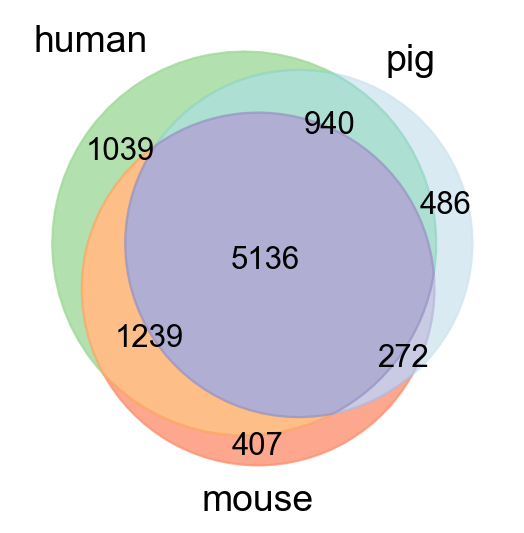

beta


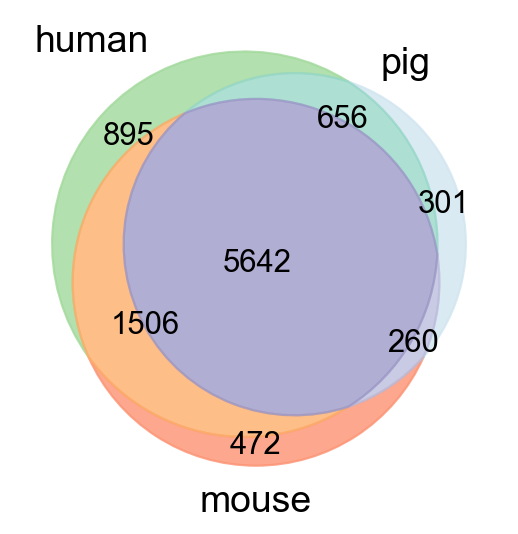

delta


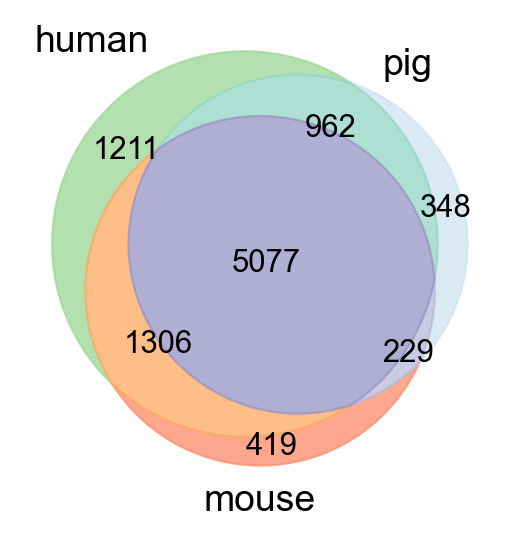

PP


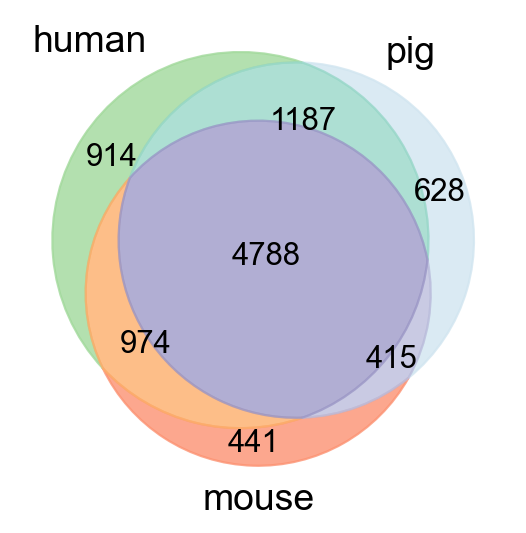

In [31]:
for key in human_comb_endo.obs.louvain_anno_broad.cat.categories:
    print(key)
    mk = venn_markers(expression_dict[key].index[expression_dict[key]['human']>0.05], 
                      expression_dict[key].index[expression_dict[key]['pig']>0.05], 
                      mouse=expression_dict[key].index[expression_dict[key]['mouse']>0.05], 
                      return_dict=True)

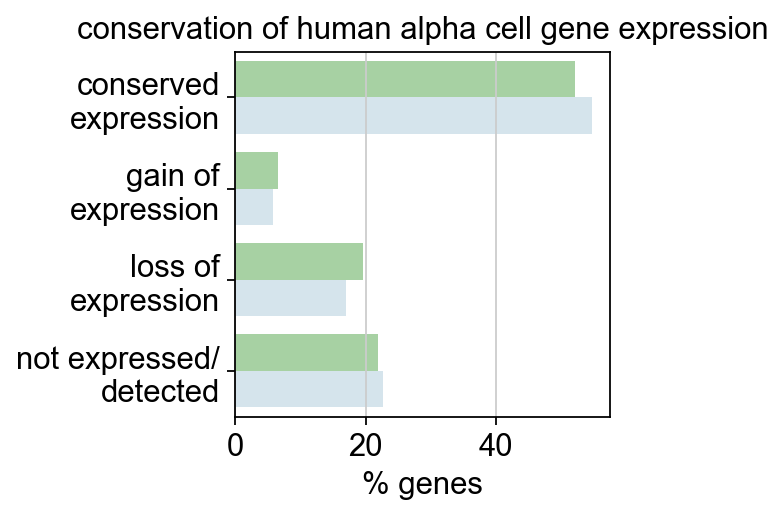

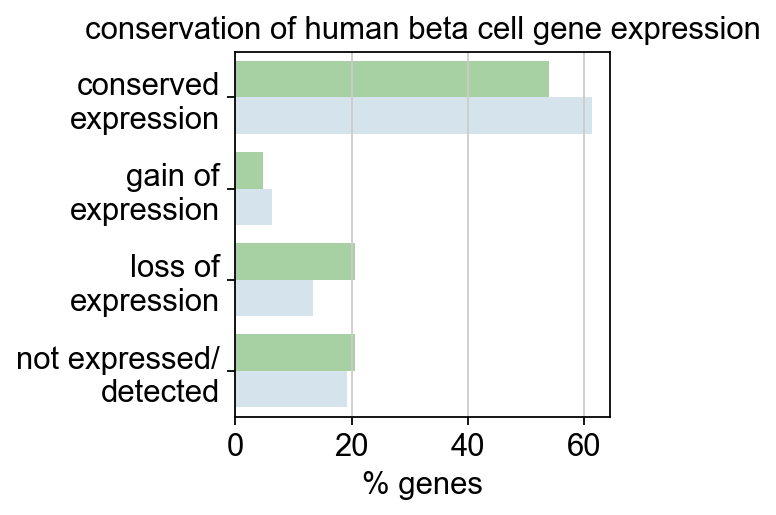

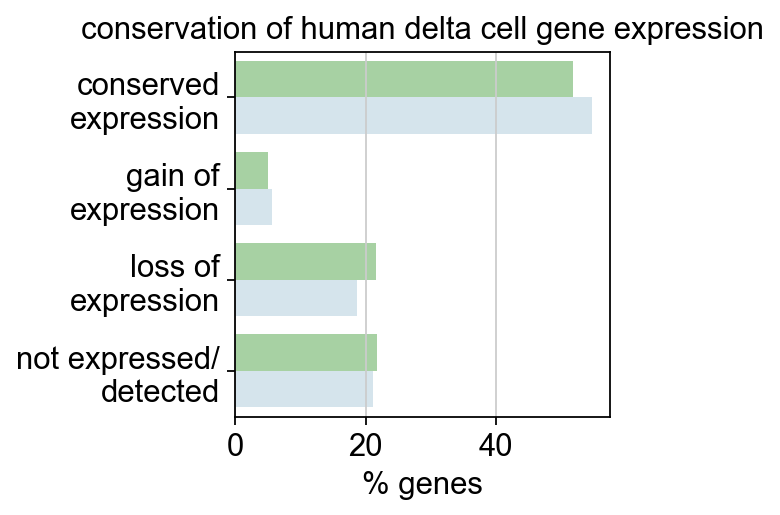

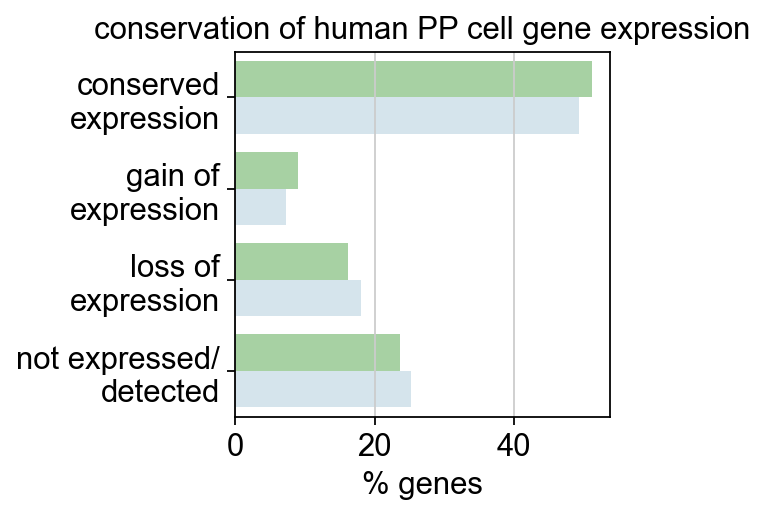

In [33]:
for key in ['alpha','beta', 'delta', 'PP']:
    df_bar = conservation_dict[key].melt()
    f, ax = pl.subplots(figsize=(3, 3))
    y='% genes'
    prop_df = (df_bar['value']
                        .groupby(df_bar['variable'])
                        .value_counts(normalize=True)
                        .rename(y)
                        .reset_index())
    prop_df[y] = prop_df[y]*100

    sns.barplot(x=y, y="value", data=prop_df, hue='variable', order=['conserved', 'gain', 'loss', 'not detected'], hue_order=['pig', 'mouse'], palette=['#a1d99b','#d1e5f0'])
    ax.set_yticklabels(['conserved\nexpression', 'gain of\nexpression', 'loss of\nexpression', 'not expressed/\ndetected'])
    ax.legend().remove()
    pl.ylabel('')
    pl.title(f'conservation of human {key} cell gene expression')

#### comparison to bulkRNA-seq Benner et al.

In [34]:
df = pd.read_excel('./data/12864_2014_6324_MOESM8_ESM.xlsx', skiprows=3)

In [35]:
df['gene name'] = df['gene name'].str.upper()

In [37]:
len(df['gene name'])

9474

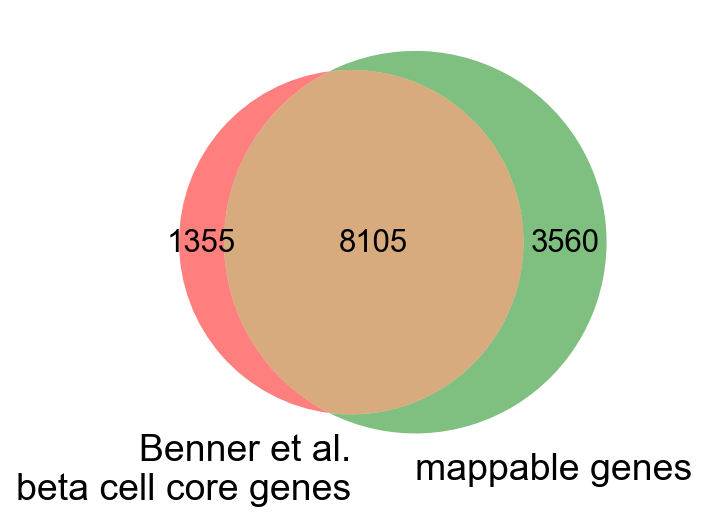

In [38]:
venn_markers(df['gene name'].tolist(),human_comb_endo.var_names,
             labels=['Benner et al.\nbeta cell core genes', 'mappable genes'],
            return_dict=False)

In [41]:
print(f'{np.round(100-(8105/9474)*100,2)}% of core gene set not mappable')

14.45% of core gene set not mappable


In [39]:
df = df.loc[[gene in human_comb_endo.var_names for gene in df['gene name']]]

In [42]:
df_map = pd.DataFrame(index=df['gene name'].tolist(), columns=['type'])

In [43]:
df_map['type'] = [conservation_dict['beta']['mouse'].loc[gene] for gene in df['gene name'].tolist()]

No handles with labels found to put in legend.


Text(0.5, 1.0, 'distribution of core beta cell gene set of Benner et al.')

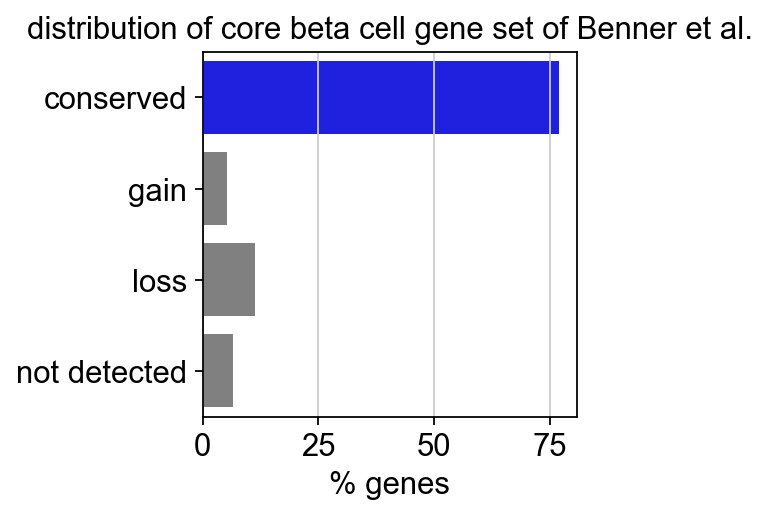

In [44]:
f, ax = pl.subplots(figsize=(3, 3))
y='% genes'
prop_df = (df_map['type'].value_counts(normalize=True).rename(y).reset_index())
prop_df[y] = prop_df[y]*100
sns.barplot(x=y, y="index", data=prop_df, order=['conserved', 'gain', 'loss', 'not detected'], palette=['blue', 'grey', 'grey', 'grey', 'lightgrey'])
#ax.set_yticklabels(['conserved\nexpression', 'gain of\nexpression', 'loss of\nexpression', 'not expressed/\ndetected'])
ax.legend().remove()
pl.ylabel('')
pl.title(f'distribution of core beta cell gene set of Benner et al.')

In [45]:
prop_df

index    % genes
0     conserved  77.014189
1          loss  11.227637
2  not detected   6.452807
3          gain   5.305367

#### Selected example genes

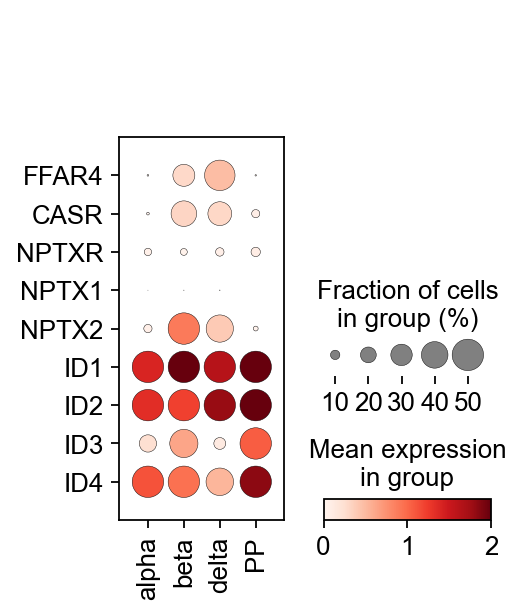

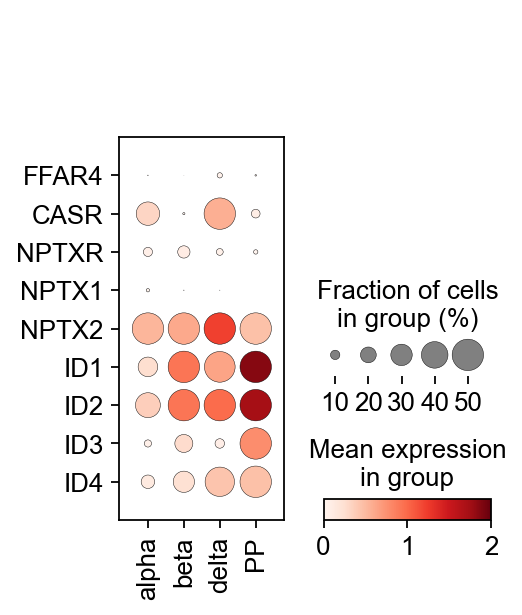

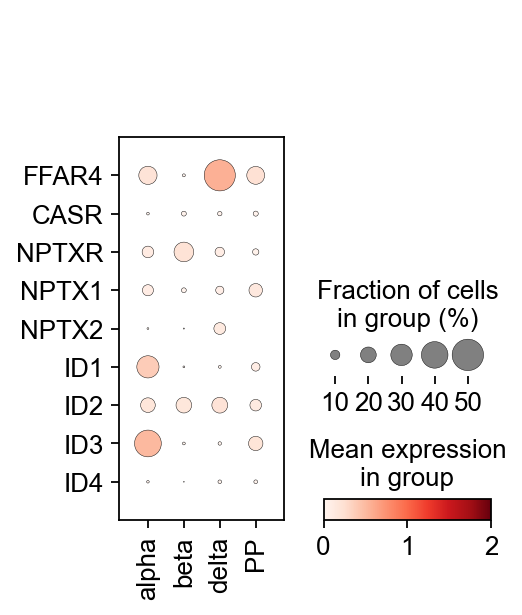

In [144]:
genes = ['FFAR4', 'CASR',  'NPTXR',  'NPTX1', 'NPTX2', 'ID1', 'ID2', 'ID3', 'ID4']
sc.pl.dotplot(human_comb_endo, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, swap_axes=True, vmin=0, vmax=2)
sc.pl.dotplot(pig_comb_endo, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, swap_axes=True, vmin=0, vmax=2)
sc.pl.dotplot(mouse_comb_endo, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, swap_axes=True, vmin=0, vmax=2)

### Conservation of enriched markers

In [48]:
mk_human = pd.read_excel('../human_islets_notebooks/output_files/marker_dict_endo_enriched.xlsx')

In [49]:
mk_pig = pd.read_excel('../pig_islets_notebooks/output_files/marker_dict_endo_enriched.xlsx')

In [50]:
mk_mouse = pd.read_excel('../mouse_islets_notebooks/output_files/marker_dict_endo_enriched.xlsx')

In [51]:
mk_human_map = {}
for col in mk_human.columns:
    mk_human_map[col] = [gene for gene in mk_human[col] if gene in conv.human_symbol.tolist()]

In [52]:
mk_pig_map = {}
for col in mk_pig.columns:
    mk_pig_map[col] = [conv.human_symbol[conv.pig_symbol==gene].values[0] for gene in mk_pig[col] if gene in conv.pig_symbol.tolist()]

In [53]:
mk_mouse_map = {}
for col in mk_mouse.columns:
    mk_mouse_map[col] = [conv.human_symbol[conv.mouse_symbol==gene].values[0] for gene in mk_mouse[col] if gene in conv.mouse_symbol.tolist()]

alpha


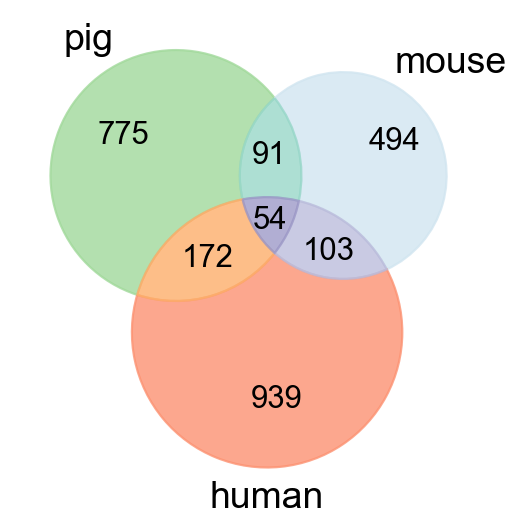

{'CLDN4', 'GRIA3', 'MDK', 'GATA6', 'SLC25A20', 'IRX2', 'SMC4', 'TMSB10', 'PAK6', 'DYNLT1', 'SERPIND1', 'NUCB1', 'KLB', 'SLC7A2', 'PLS3', 'HN1', 'MGAT4B', 'GPR137B', 'ACTG1', 'PDE4D', 'SEMA3E', 'NBEAL2', 'MYO1B', 'MAMLD1', 'KCNJ3', 'GLUD1', 'A1CF', 'C1orf21', 'GNAI1', 'SLC25A33', 'GCG', 'VASP', 'CRYBA2', 'CTSZ', 'IGFBP7', 'PAPPA2', 'ZNRF1', 'EFHD2', 'EFNA1', 'IFIH1', 'POU6F2', 'LMO4', 'BCAM', 'RHOC', 'RAB3C', 'HMGB3', 'GLS', 'GALNS', 'FAM107B', 'PSMB10', 'PDK4', 'PCSK2', 'TTR', 'ARRDC4'}
beta


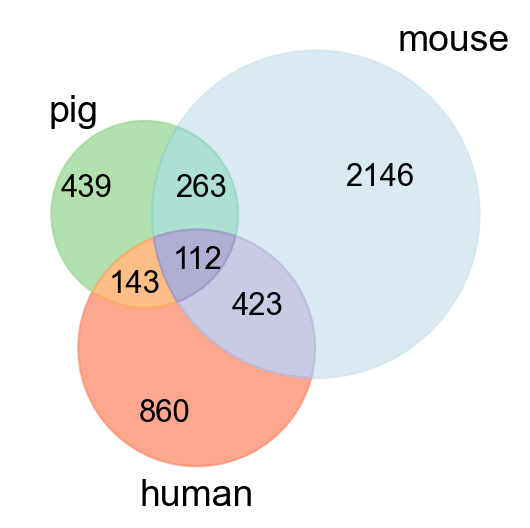

{'NR1D2', 'COBLL1', 'DAAM1', 'CACNA1D', 'SLC25A29', 'GJD2', 'MEGF9', 'CABP7', 'G6PC2', 'ENPP5', 'VEGFB', 'TMEM64', 'ENAH', 'CDC37L1', 'BHLHE41', 'C16orf72', 'DSTYK', 'TTC7B', 'MXRA7', 'USP2', 'DCX', 'PKIB', 'PIGA', 'FAM102A', 'FOXO1', 'NKX6-1', 'NUDT7', 'PPP1R1A', 'SLC30A8', 'SETD7', 'PREB', 'MSMO1', 'TMEM135', 'FAM222A', 'NHLRC3', 'TMEM50B', 'ATMIN', 'PDX1', 'VEGFA', 'OTUD3', 'TBC1D8', 'PLCL2', 'MT2A', 'ABAT', 'PAPD5', 'USP6NL', 'SLC2A13', 'CDK14', 'CYP2U1', 'HSPA1B', 'NLK', 'UBTD1', 'TNFAIP8', 'ZC3H3', 'DNAJB9', 'ABCA3', 'TMEM189', 'LMO1', 'KLHL2', 'CISH', 'ELAVL4', 'FICD', 'TP53INP2', 'GLIS3', 'SYT7', 'C12orf49', 'SPATA13', 'TRIM41', 'DBP', 'PCSK1', 'NR1D1', 'KAT2B', 'MT-CYB', 'WNT4', 'SLC35D3', 'FLCN', 'SLC2A2', 'BMI1', 'RASGRF1', 'ADRBK2', 'PTPRU', 'ELMO1', 'TSHZ1', 'GOLGB1', 'DOCK10', 'MLXIPL', 'JADE2', 'ERO1LB', 'ZFP36L2', 'ACLY', 'SORL1', 'AACS', 'C1orf51', 'REPS2', 'NEGR1', 'CEBPB', 'GPR158', 'FAM117A', 'MT-ATP6', 'INS', 'ZMAT3', 'HADH', 'HOPX', 'CREBRF', 'NFE2L1', 'KCNMA1', '

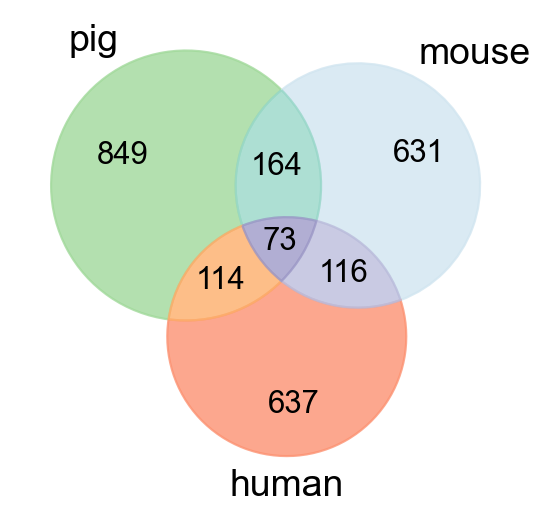

{'ZNF365', 'RABGAP1L', 'C3orf58', 'HSPB11', 'PROX1', 'EHF', 'SORD', 'UCHL1', 'TMEM237', 'FXYD6', 'ATXN10', 'TMEM59L', 'H3F3C', 'PAK3', 'EXOC6', 'MAN2A1', 'KCTD8', 'PBXIP1', 'PCDH9', 'CTXN1', 'TGIF1', 'VAT1L', 'VIM', 'HPCAL1', 'PRKCDBP', 'BTG2', 'ETV1', 'FGGY', 'PROS1', 'ACOT7', 'RBP1', 'HAUS1', 'CACNA2D2', 'SIM1', 'MAPK13', 'CDO1', 'CLSTN3', 'LRRC42', 'S100A10', 'BAMBI', 'ISL1', 'HAP1', 'LRRC49', 'TAGLN3', 'HHEX', 'SST', 'RBP4', 'UCP2', 'RHOC', 'PBX1', 'NRP2', 'PPFIA2', 'TSPO', 'CHGB', 'TMED6', 'MEST', 'GABRB3', 'TMEM130', 'AKAP7', 'LY6H', 'ST6GALNAC5', 'MOV10', 'KRT8', 'HMGN2', 'FGF14', 'PLEKHB1', 'NAB2', 'AMIGO2', 'CAPSL', 'TSPAN15', 'SYT1', 'TSPAN6', 'ST14'}
PP


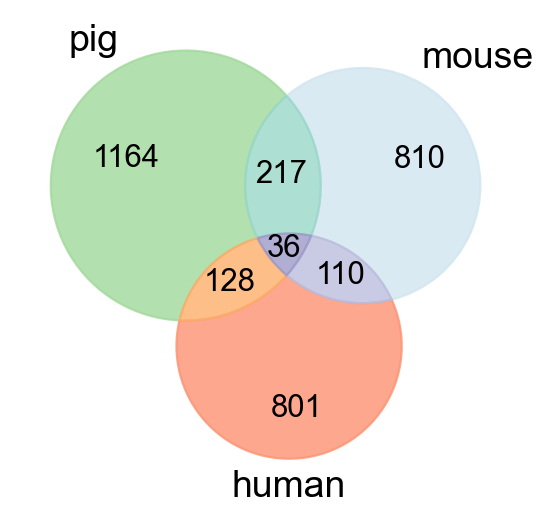

{'DMD', 'IFNGR2', 'PPY', 'HMGXB4', 'TMSB10', 'ID3', 'PLS3', 'EGR2', 'TUBB2B', 'LGMN', 'VMP1', 'PROS1', 'ETV1', 'PTP4A3', 'STMN1', 'TMEM176A', 'CLSTN3', 'FGFR1', 'CRIP2', 'HNMT', 'ID1', 'ARMCX4', 'ITM2C', 'IFT122', 'OCLN', 'TAPBPL', 'MOV10', 'RNF128', 'LGALS3BP', 'SMAD7', 'CRAT', 'PLEKHB1', 'FGF14', 'DZIP3', 'PSMB10', 'ARNT2'}


In [101]:
genes = []
for key in mk_human_map.keys():
    print(key)
    mk = venn_markers(mk_pig_map[key], mk_mouse_map[key],mk_human_map[key], labels=['pig', 'mouse', 'human'], return_dict=True)
    genes = genes + list(mk['h_p_m'])
    print(mk['h_p_m'])

In [98]:
enrichment_conservation_dict = {}

for key in ['alpha','beta', 'delta', 'PP']:

    refs = list(human_comb_endo.obs.louvain_anno_broad.cat.categories)
    refs.remove(key)
    genes_human = mk_human_map[key]
    df = pd.DataFrame(index=genes_human, columns=['mouse', 'pig'])  
    
    detected_key = expression_dict_species['pig']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['pig'] = ['conserved' if gene in mk_pig_map[key] else
                            'switch' if gene in mk_pig_map[refs[0]]+mk_pig_map[refs[1]]+mk_pig_map[refs[2]] else
                            'loss' if gene in detected_key else
                            'not detected' for gene in genes_human]
    
    df['pig_detected'] = ['detected' if gene in detected_key else
                            'not detected' for gene in genes_human]
    
    detected_key = expression_dict_species['mouse']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['mouse'] = ['conserved' if gene in mk_mouse_map[key] else
                            'switch' if gene in mk_mouse_map[refs[0]]+mk_mouse_map[refs[1]]+mk_mouse_map[refs[2]] else
                            'loss' if gene in detected_key else
                            'not detected' for gene in genes_human]
    
    df['mouse_detected'] = ['detected' if gene in detected_key else
                            'not detected' for gene in genes_human]
    enrichment_conservation_dict[key]=df

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


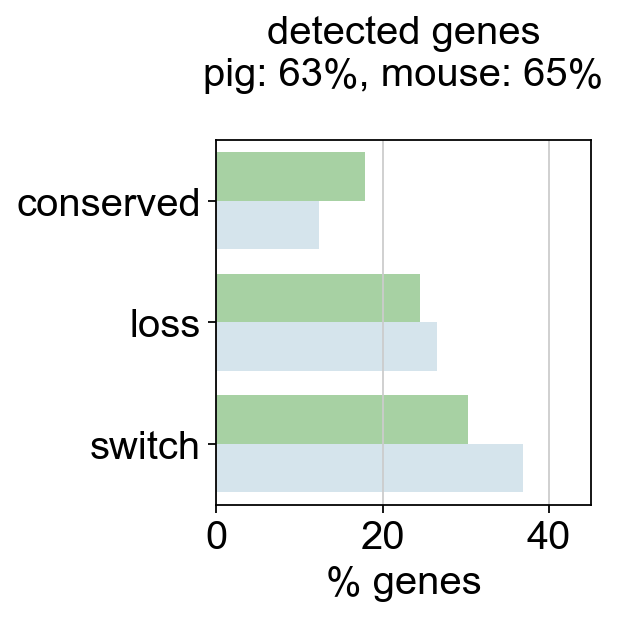

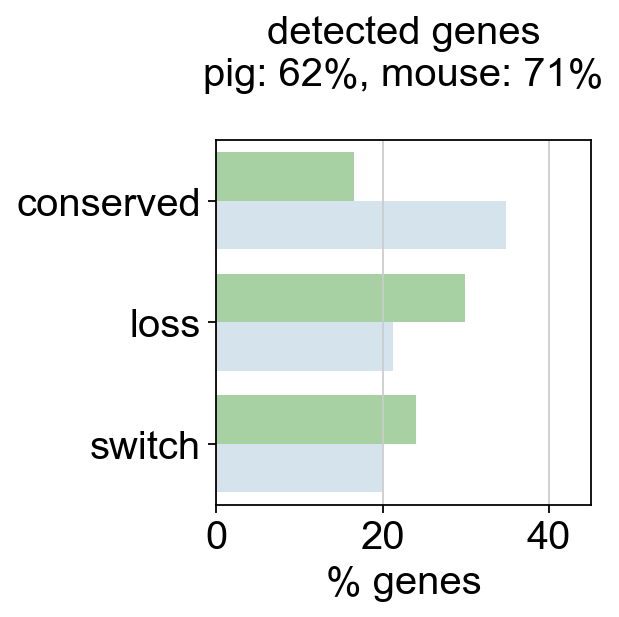

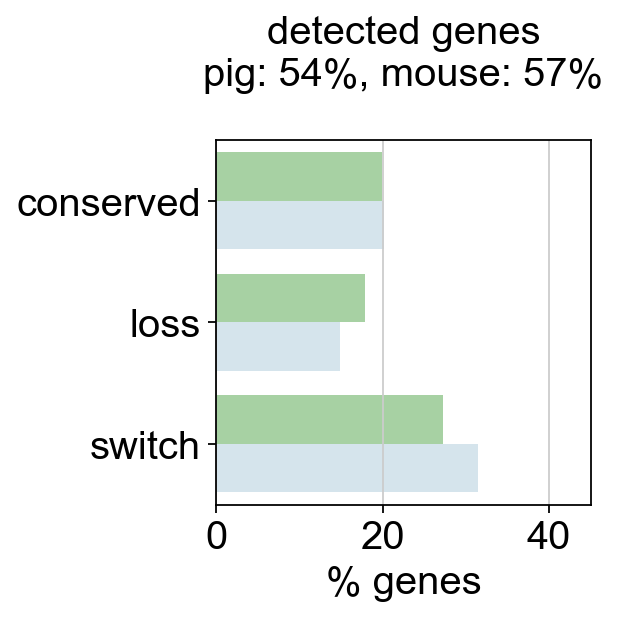

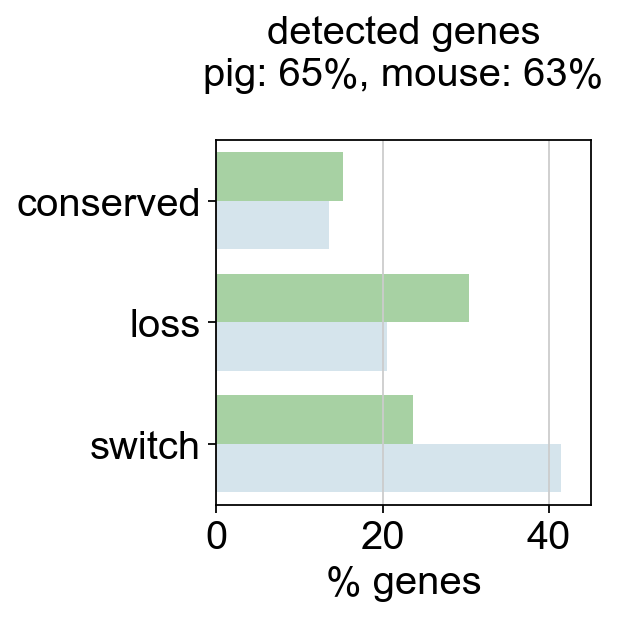

In [339]:
for key in ['alpha','beta', 'delta', 'PP']:
    df_bar = enrichment_conservation_dict[key][['pig', 'mouse']].melt()
    df = enrichment_conservation_dict[key][['pig_detected', 'mouse_detected']]=='detected'
    sum_pig = round(df.sum()['pig_detected']/len(mk_human_map[key])*100)
    sum_mouse = round(df.sum()['mouse_detected']/len(mk_human_map[key])*100)
    f, ax = pl.subplots(figsize=(3, 3))
    y='% genes'
    prop_df = (df_bar['value']
                        .groupby(df_bar['variable'])
                        .value_counts(normalize=True)
                        .rename(y)
                        .reset_index())
    prop_df[y] = prop_df[y]*100

    sns.barplot(x=y, y="value", data=prop_df, hue='variable', order=['conserved', 'loss', 'switch'], hue_order=['pig', 'mouse'], palette=['#a1d99b','#d1e5f0'])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.set_xticklabels([0,20,40], fontsize=18)
    ax.legend().remove()
    pl.ylabel('')
    pl.xlabel('% genes', fontsize=18)
    pl.xlim([0,45])
    pl.title(f'detected genes\npig: {sum_pig}%, mouse: {sum_mouse}%\n ', fontsize=18)

#### Supplementary Table 2

In [99]:
writer = pd.ExcelWriter('./Supplementary_table_2.xlsx')

for key in ['alpha', 'beta', 'delta', 'PP']:
    enrichment_conservation_dict[key][['pig', 'mouse', 'pig_detected', 'mouse_detected']].to_excel(writer, sheet_name=f'{key}_human_marker_conservation')
    if len(mk_pig_map[key])>len(mk_mouse_map[key]):
        df = pd.DataFrame(mk_pig_map[key] , columns=['pig markers'])
        df['mouse markers'] =  pd.Series(mk_mouse_map[key])
    else:
        df = pd.DataFrame(mk_mouse_map[key] , columns=['mouse markers'])
        df['pig markers'] =  pd.Series(mk_pig_map[key])
        df = df[['pig markers', 'mouse markers']].copy()
    df.to_excel(writer, sheet_name=f'{key}_pig_mouse_markers')
writer.save()

### Conservation of transcription factors

[Text(0.5, 0, 'alpha'),
 Text(1.5, 0, 'beta'),
 Text(2.5, 0, 'delta'),
 Text(3.5, 0, 'PP')]

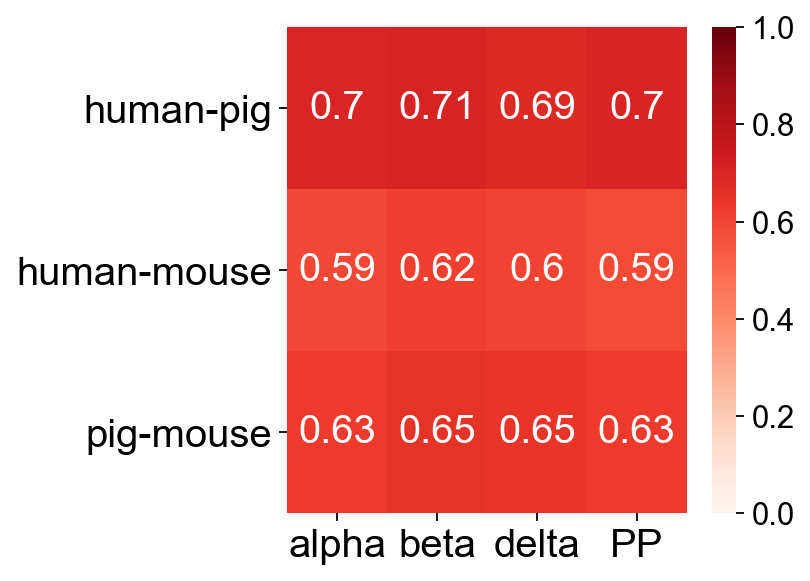

In [418]:
df.index = ['human-pig', 'human-mouse', 'pig-mouse']
ax = sns.heatmap(df.apply(pd.to_numeric), vmin=0, vmax=1, cmap='Reds', annot=df, annot_kws={'fontsize':18})
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

#### Conserved human marker TFs

In [419]:
tfs = pd.read_csv('./data/TF_names_v_1.01_human.txt',sep='\t',header=None).unstack().tolist()

In [420]:
mk_tf = {}
for cat in mk_human_map.keys():
    tfs_h = [tf for tf in mk_human_map[cat] if tf in tfs]
    tfs_p = [tf for tf in mk_pig_map[cat] if tf in tfs]
    tfs_m = [tf for tf in mk_mouse_map[cat] if tf in tfs]
    
    mk_tf[cat] = list(set(tfs_h).intersection(tfs_p).intersection(tfs_m))

alpha


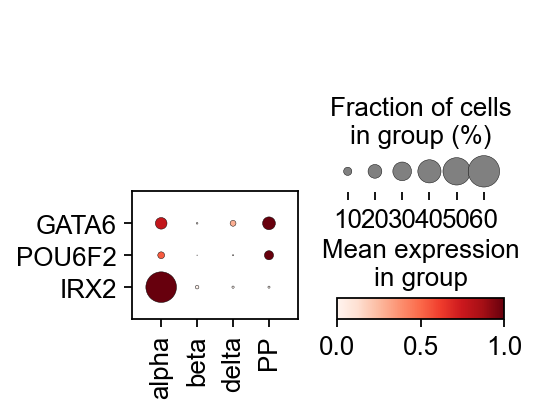

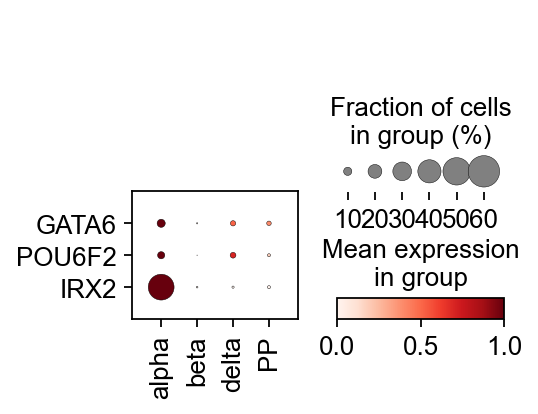

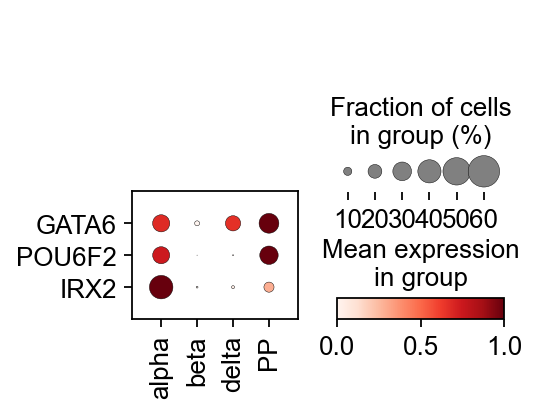

beta


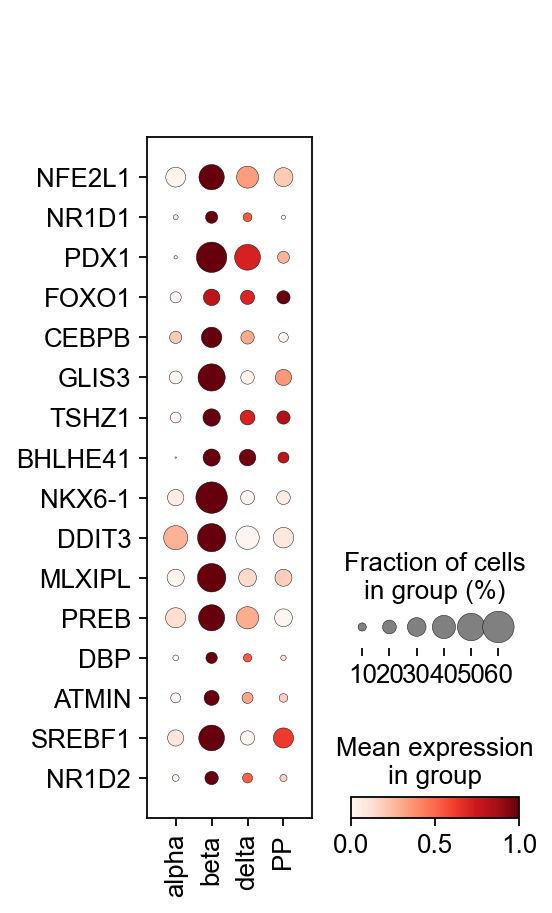

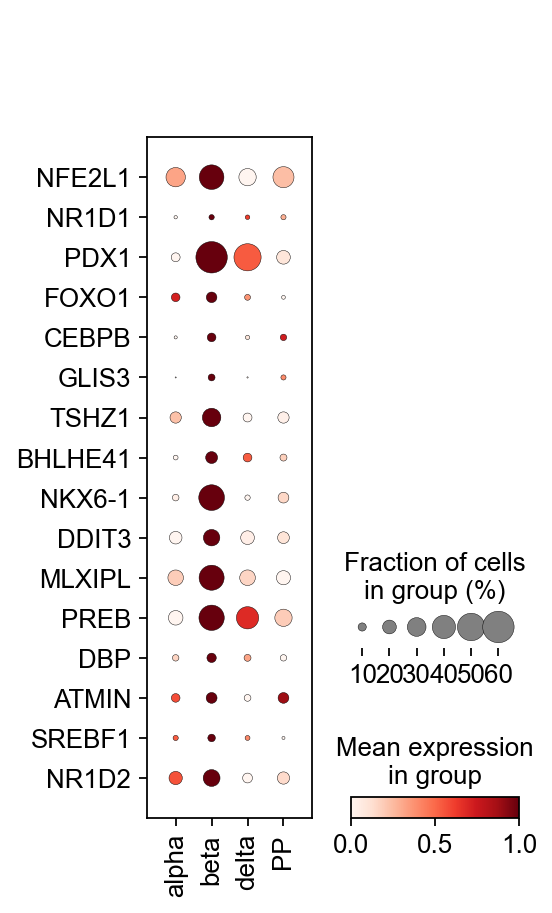

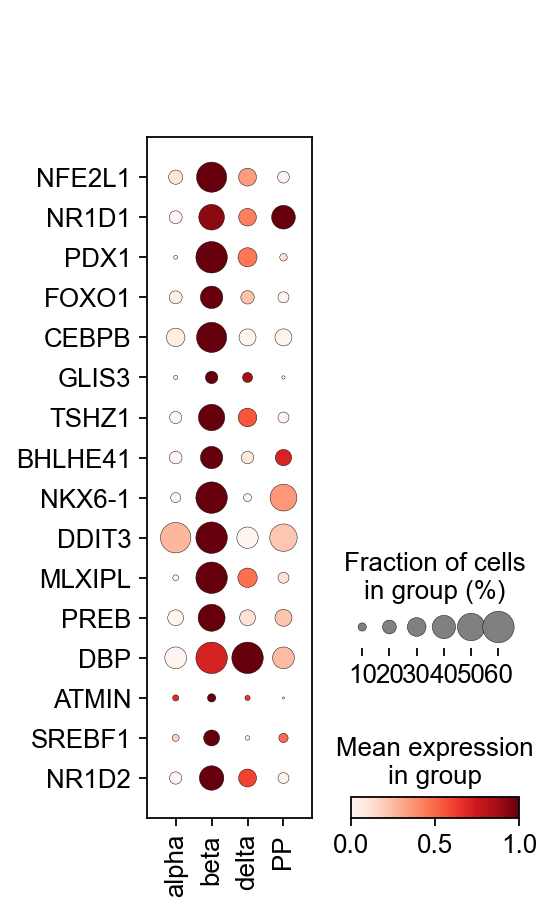

delta


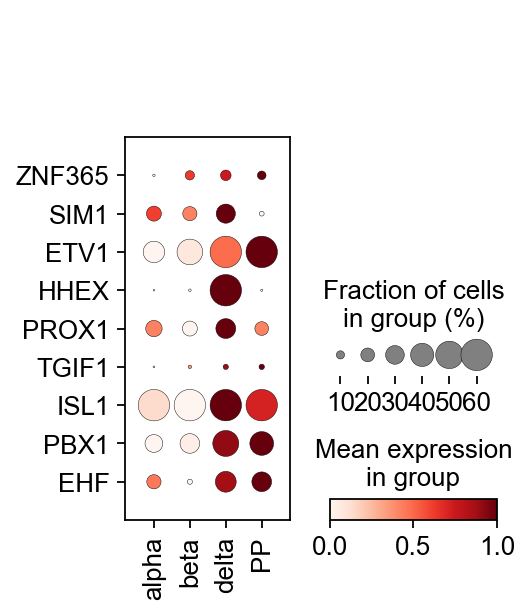

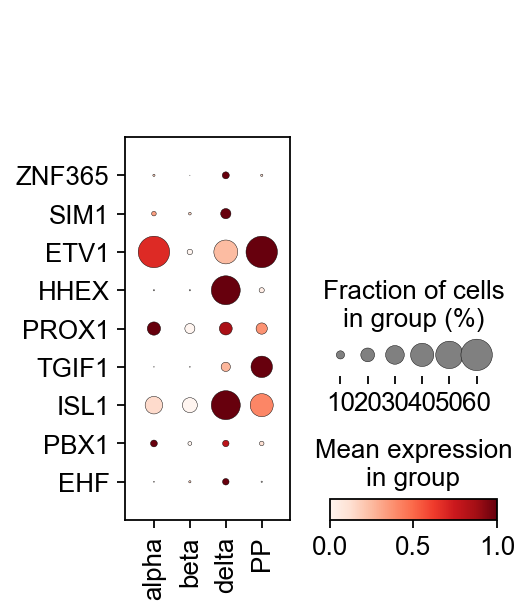

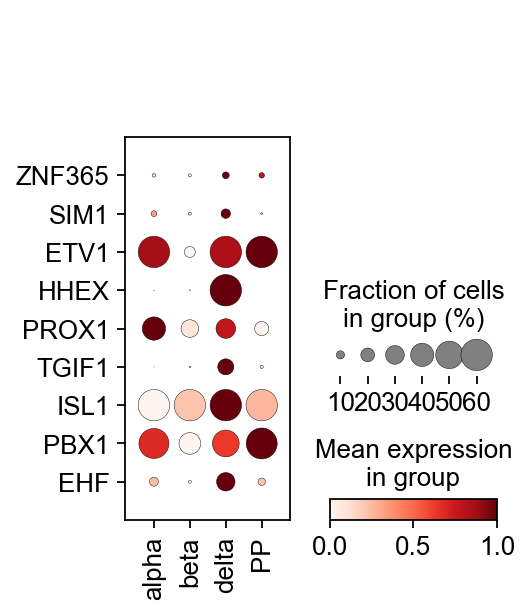

PP


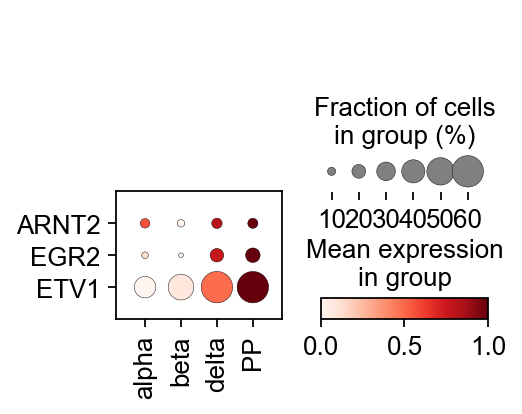

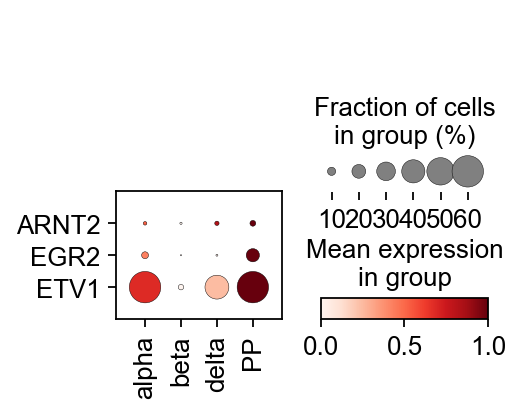

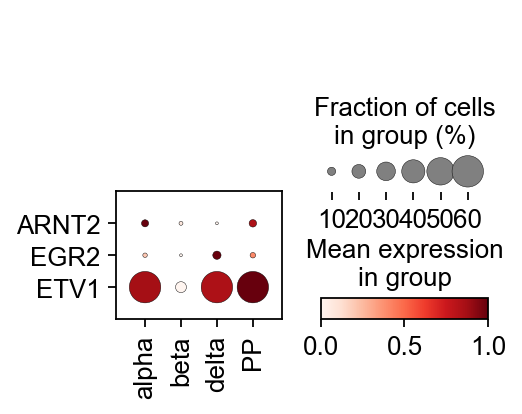

In [535]:
for key in mk_tf.keys():
    print(key)
    sc.pl.dotplot(human_comb_endo, groupby='louvain_anno_broad', var_names=mk_tf[key], standard_scale='var', dot_max=0.6, swap_axes=True)
    sc.pl.dotplot(pig_comb_endo, groupby='louvain_anno_broad', var_names=mk_tf[key], standard_scale='var', dot_max=0.6, swap_axes=True)
    sc.pl.dotplot(mouse_comb_endo, groupby='louvain_anno_broad', var_names=mk_tf[key], standard_scale='var', dot_max=0.6, swap_axes=True)

alpha: 3 TFs
human


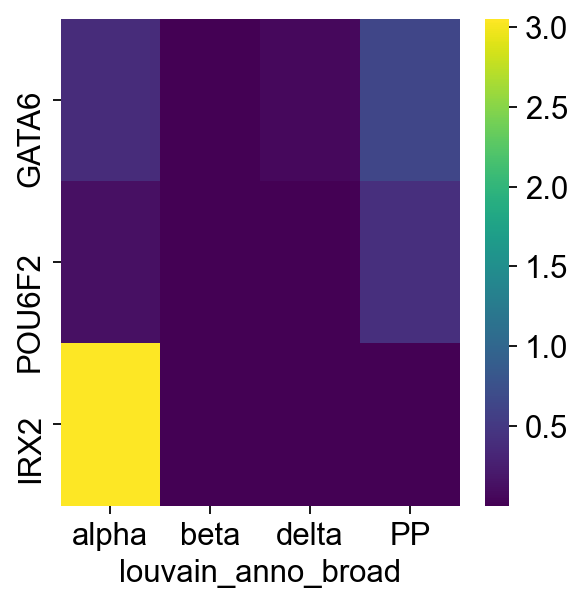

pig


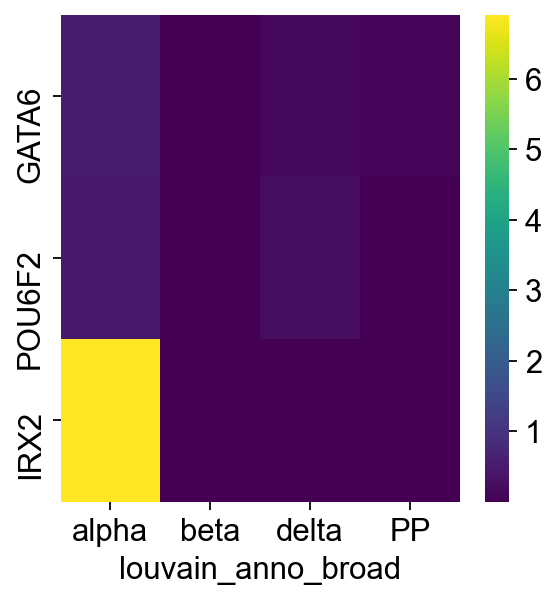

mouse


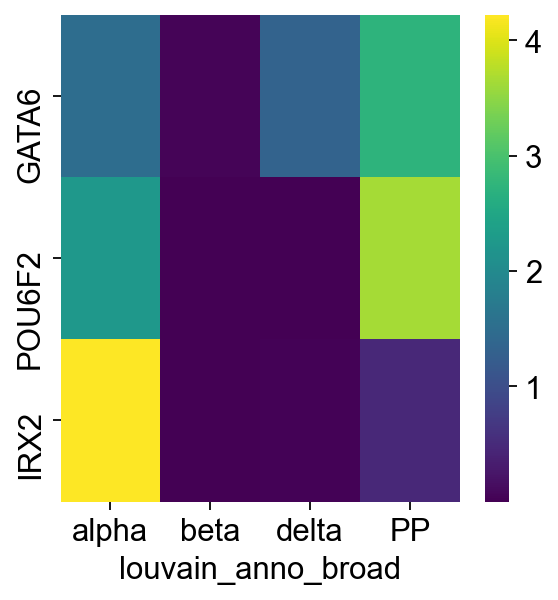

human-pig
across cell types: 0.9709336671989178 1.556129109668826e-07
wihtin cell type: 0.9975647548231166 0.04443801391123098
human-mouse
across cell types: 0.7346088062961538 0.006505489673579389
wihtin cell type: 0.9386781763541456 0.22410283112739218
pig-mouse
across cell types: 0.6069349109744802 0.036373394558989386
wihtin cell type: 0.9604404424718045 0.1796648172161598
beta: 16 TFs
human


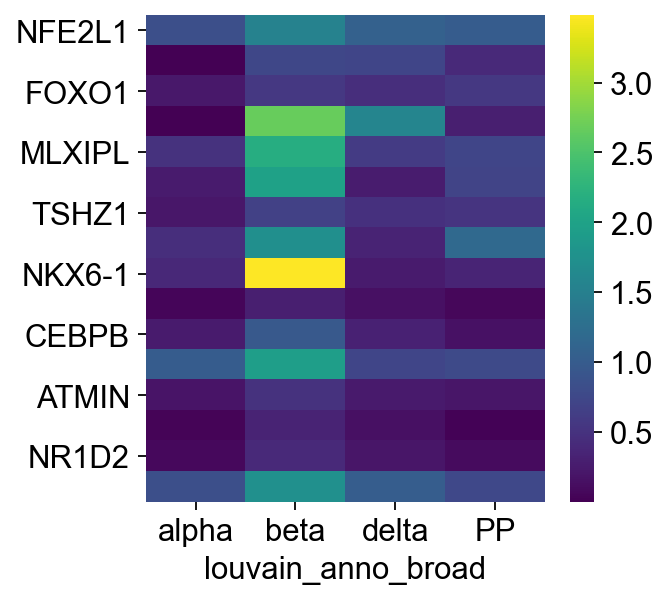

pig


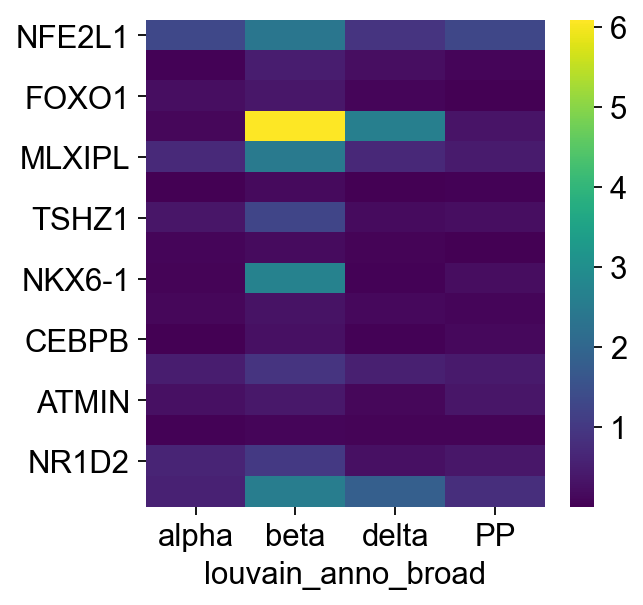

mouse


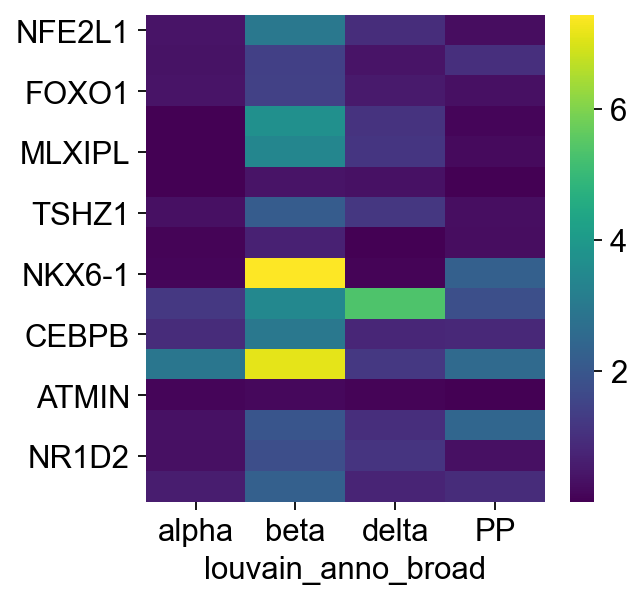

human-pig
across cell types: 0.7383577895972219 3.3380216211413956e-12
wihtin cell type: 0.649632855147679 0.006455745361842287
human-mouse
across cell types: 0.572211052662152 7.823393867942813e-07
wihtin cell type: 0.5850079876459933 0.017293141757678918
pig-mouse
across cell types: 0.44302937598591063 0.00024630674344139564
wihtin cell type: 0.4007135624119767 0.12401679337753611
delta: 9 TFs
human


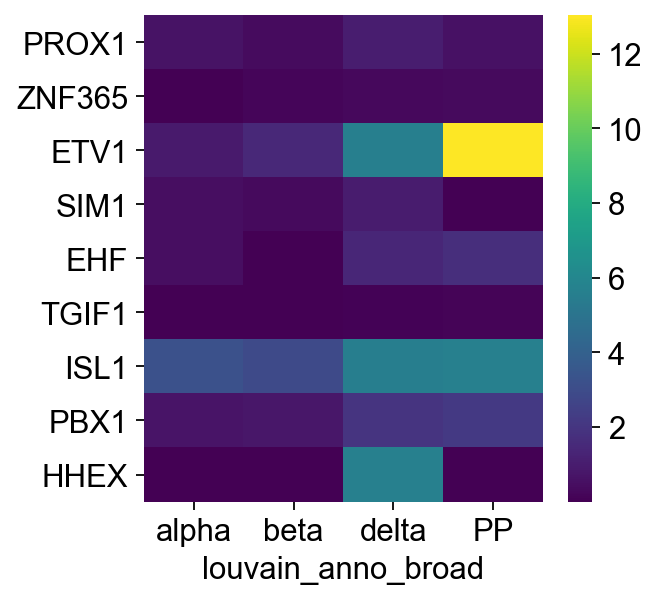

pig


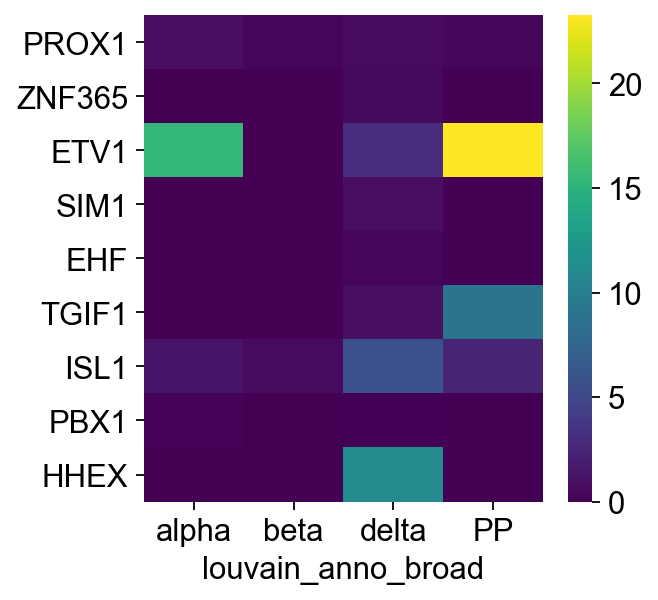

mouse


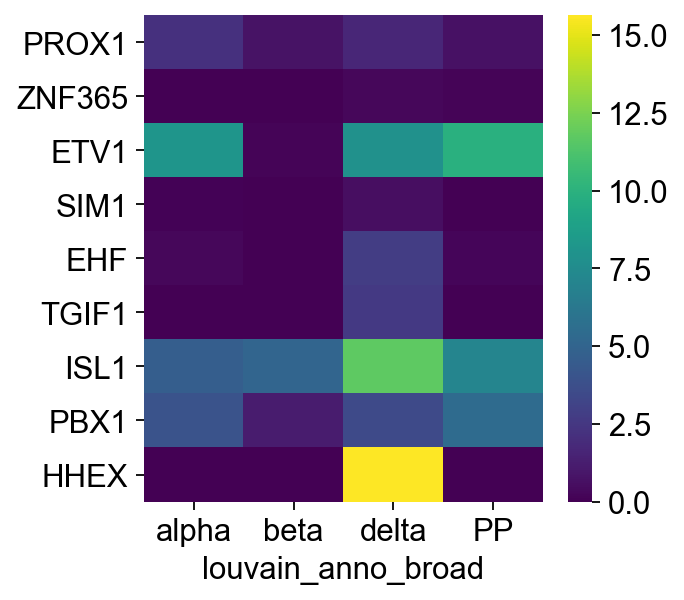

human-pig
across cell types: 0.7144404910486889 9.886520410537122e-07
wihtin cell type: 0.7932468782146418 0.010738318778355
human-mouse
across cell types: 0.7784725264925446 2.2766719386839068e-08
wihtin cell type: 0.9129859787984749 0.0005871855161109546
pig-mouse
across cell types: 0.660951158339924 1.145373151906488e-05
wihtin cell type: 0.9471247944512371 0.00010626241368300271
PP: 3 TFs
human


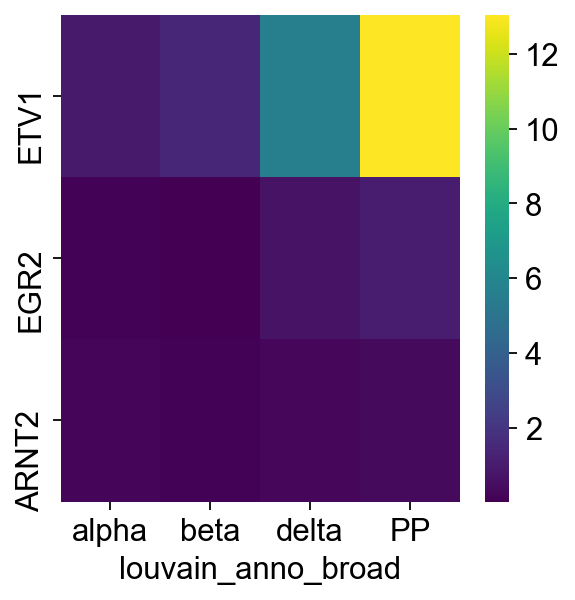

pig


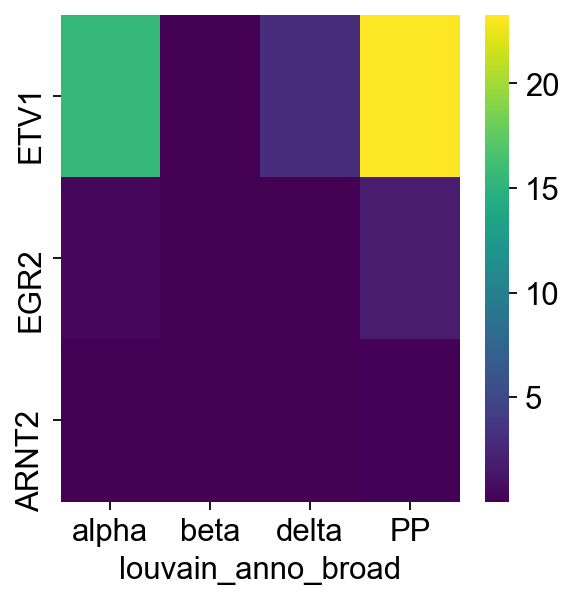

mouse


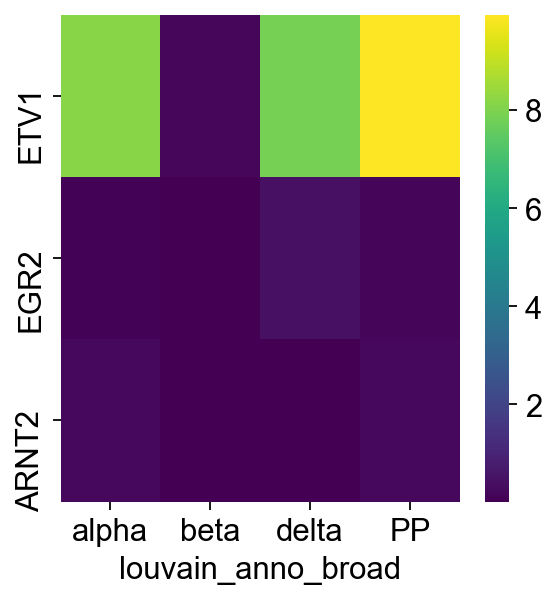

human-pig
across cell types: 0.7856738185292855 0.002453849438748189
wihtin cell type: 0.9999168096452821 0.008211729210373735
human-mouse
across cell types: 0.7872561266104651 0.002371387328329492
wihtin cell type: 0.9980868060273004 0.03938618240781258
pig-mouse
across cell types: 0.8679069143043521 0.00025267448801057784
wihtin cell type: 0.9972062776970392 0.04759791161819072


In [421]:
# TF pattern correlation

df = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])
df_p = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])

for key in mk_tf.keys():
    
    print(f'{key}: {len(mk_tf[key])} TFs')

    adata_dict = {
        'human': sc.pp.scale(human_comb_endo[:, mk_tf[key]], zero_center=False, copy=True),
        'pig': sc.pp.scale(pig_comb_endo[:, mk_tf[key]], zero_center=False, copy=True),
        'mouse': sc.pp.scale(mouse_comb_endo[:, mk_tf[key]], zero_center=False, copy=True)
    }  
    
    mean_dict = {}
    for k, v in adata_dict.items():
        mean_dict[k] = sc.get.obs_df(
            v,
            keys=['louvain_anno_broad'] + mk_tf[key]
        ).groupby('louvain_anno_broad').mean().T.loc[mk_tf[key]]      
        
    frac_expressed_dict = {}
    for s in ['human', 'pig', 'mouse']:
        frac_expressed_dict[s] = expression_dict_species[s].loc[mk_tf[key]] / expression_dict_species[s].mean(axis=0)

    harmonic_avg = {}
    for s in ['human', 'pig', 'mouse']:
        print(s)        
        harmonic_avg[s] = mean_dict[s] * frac_expressed_dict[s]
        sns.heatmap(harmonic_avg[s], cmap='viridis')
        pl.show()       
        
    for i, combi in enumerate(itertools.combinations(['human', 'pig', 'mouse'], 2)):
        print('-'.join(combi))
        rho, p = pearsonr(harmonic_avg[combi[0]].values.flatten(), harmonic_avg[combi[1]].values.flatten())
        print('across cell types:', rho, p)
        df.loc[i, key] = rho
        df_p.loc[i, key] = round(p,4)
        
        rho, p = pearsonr(harmonic_avg[combi[0]][key], harmonic_avg[combi[1]][key])
        print('wihtin cell type:', rho, p)


[Text(0.5, 0, 'alpha'),
 Text(1.5, 0, 'beta'),
 Text(2.5, 0, 'delta'),
 Text(3.5, 0, 'PP')]

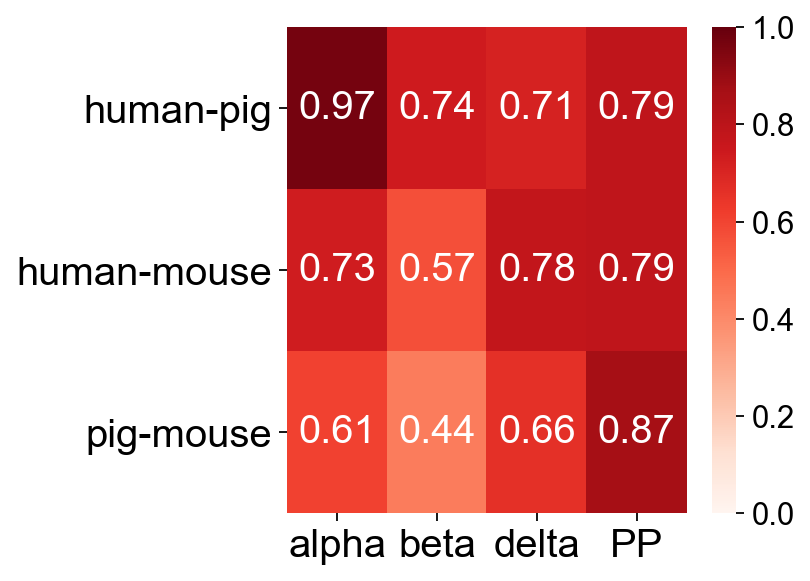

In [422]:
df.index = ['human-pig', 'human-mouse', 'pig-mouse']
ax = sns.heatmap(df.apply(pd.to_numeric), vmin=0, vmax=1, cmap='Reds', annot=df, annot_kws={'fontsize':18})
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

#### enriched human marker TFs

In [396]:
tfs = pd.read_csv('./data/TF_names_v_1.01_human.txt',sep='\t',header=None).unstack().tolist()

In [423]:
mk_human_tf = {}

for key in mk_human_map.keys():
    mk_human_tf[key] = [tf for tf in mk_human_map[key] if tf in tfs]

alpha: 59 TFs
human


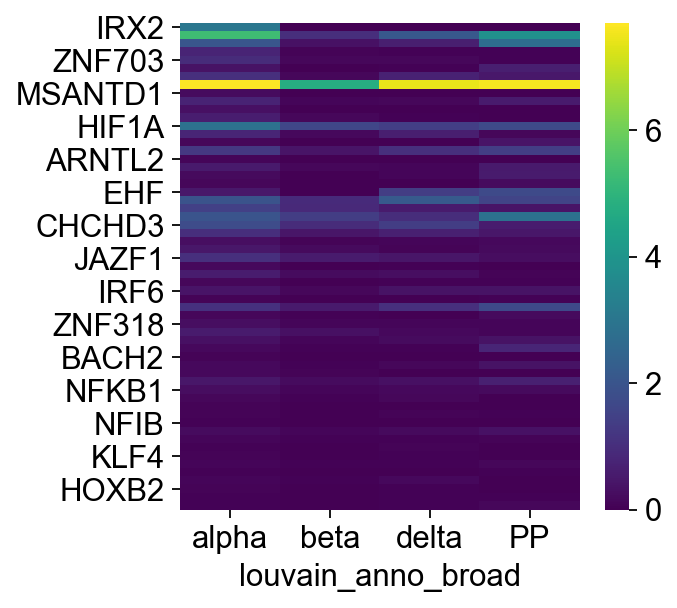

pig


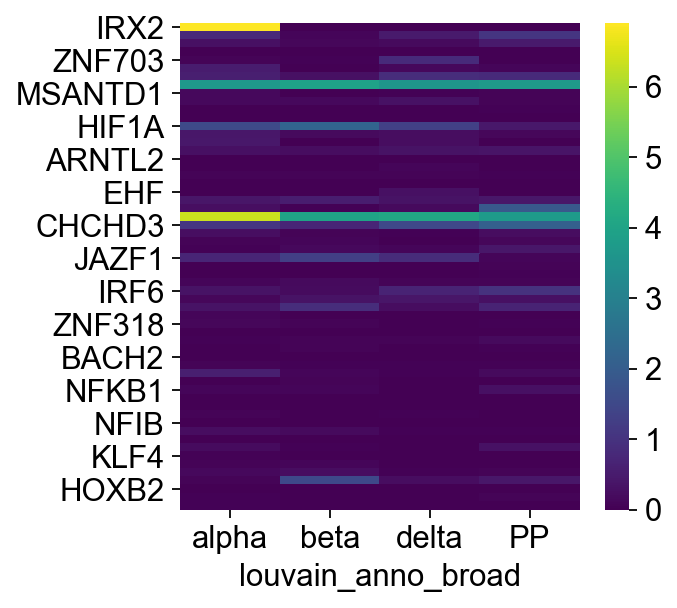

mouse


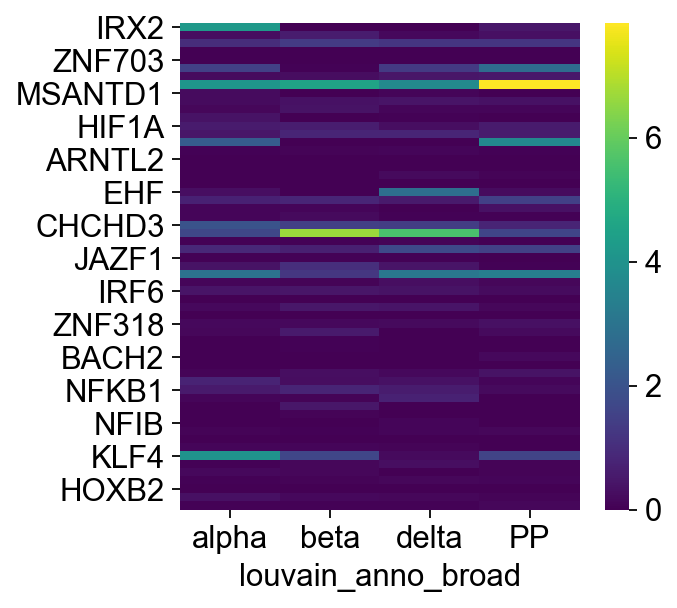

human-pig
across cell types: 0.651183458484484 7.355476645573886e-30
wihtin cell type: 0.5833312812108141 1.2437501640087495e-06
human-mouse
across cell types: 0.5243834056169697 4.503874491174406e-18
wihtin cell type: 0.48060841570970797 0.00011685060724663315
pig-mouse
across cell types: 0.3716443107524138 3.830300642026035e-09
wihtin cell type: 0.483265659202564 0.00010573636373610877
beta: 129 TFs
human


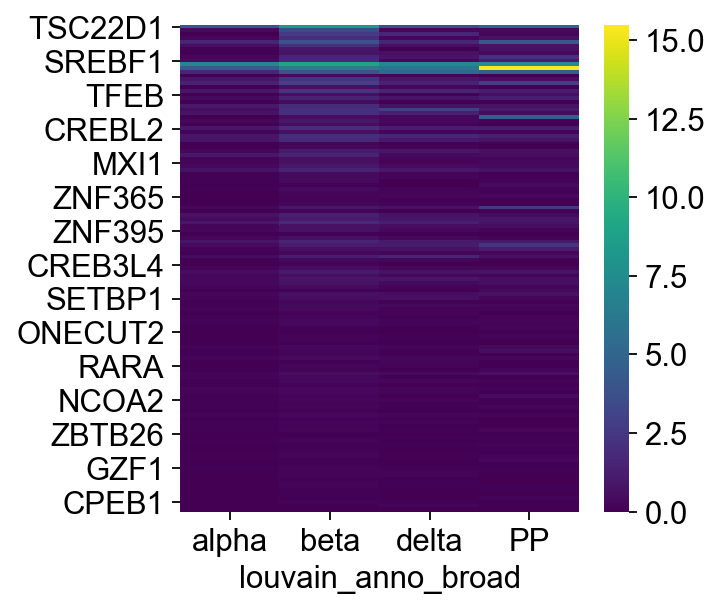

pig


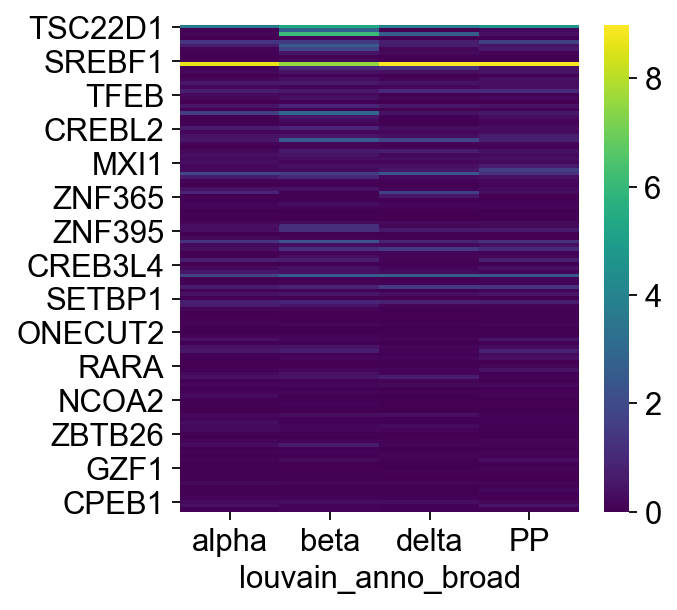

mouse


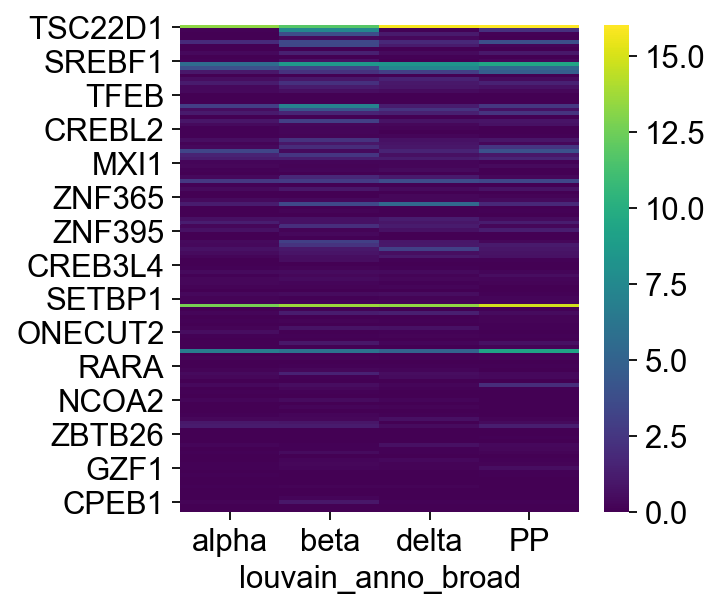

human-pig
across cell types: 0.6111196716077082 3.743436774779521e-54
wihtin cell type: 0.7230559856356941 3.836120801013668e-22
human-mouse
across cell types: 0.5223524914731222 1.8327898121834437e-37
wihtin cell type: 0.6141359770666266 9.960904701152045e-15
pig-mouse
across cell types: 0.5267287870545377 3.569397203349373e-38
wihtin cell type: 0.5809168675418422 5.314659306397346e-13
delta: 57 TFs
human


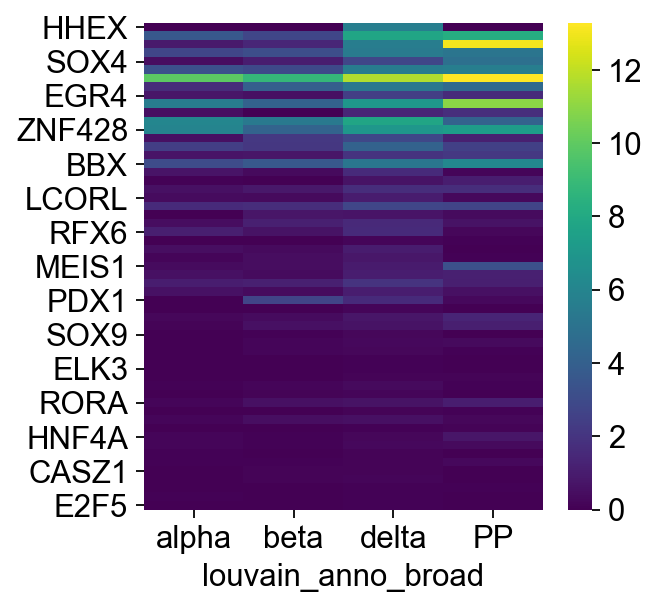

pig


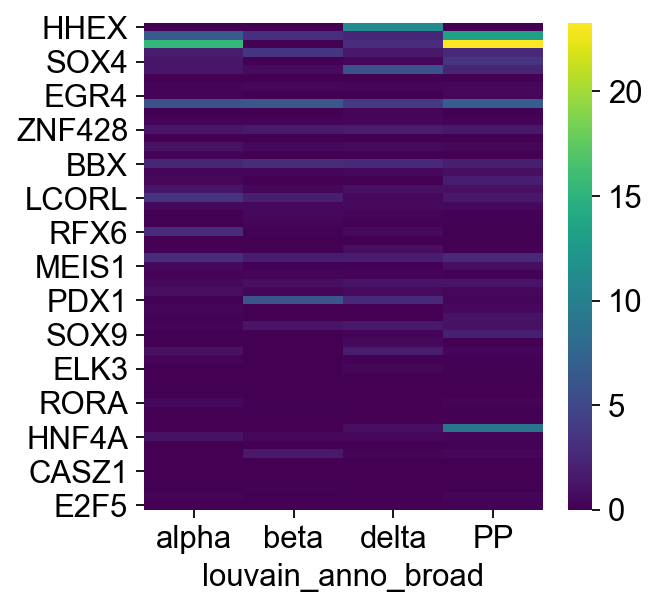

mouse


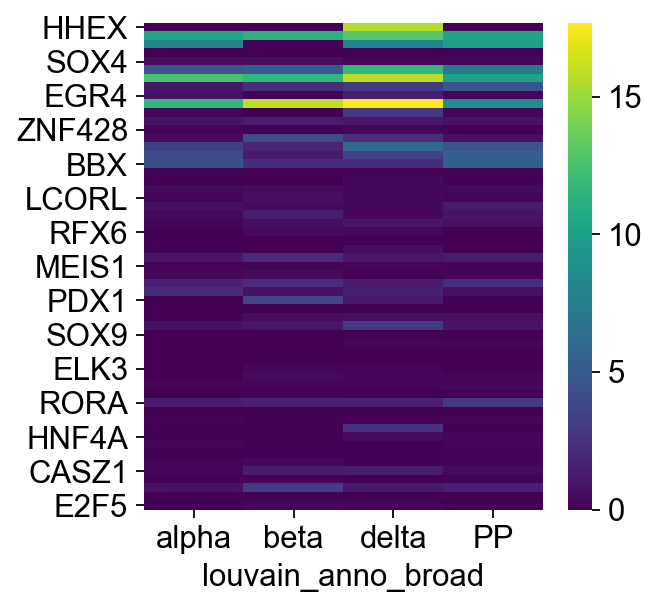

human-pig
across cell types: 0.46771165118927305 8.568018709213732e-14
wihtin cell type: 0.4443302245580549 0.0005351558759990366
human-mouse
across cell types: 0.7098796988484612 2.9363008037081282e-36
wihtin cell type: 0.7312112898417994 1.0538246305242127e-10
pig-mouse
across cell types: 0.532332405230033 4.378556776210525e-18
wihtin cell type: 0.6699931731266039 1.1990463234295202e-08
PP: 100 TFs
human


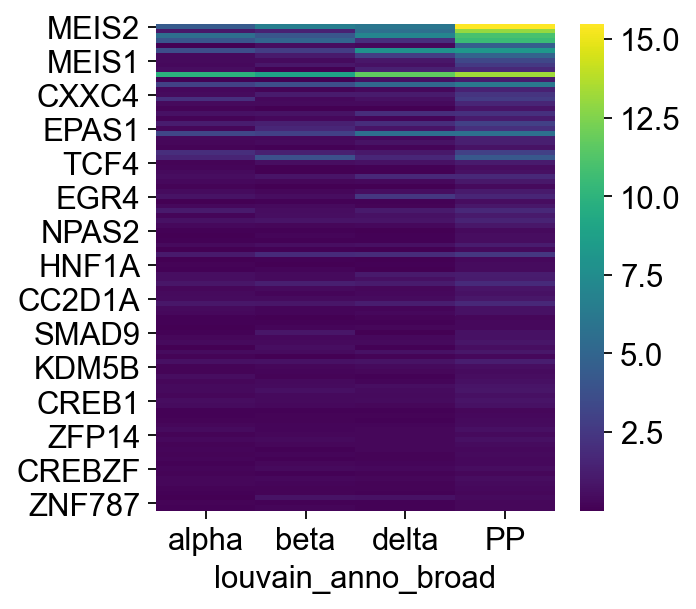

pig


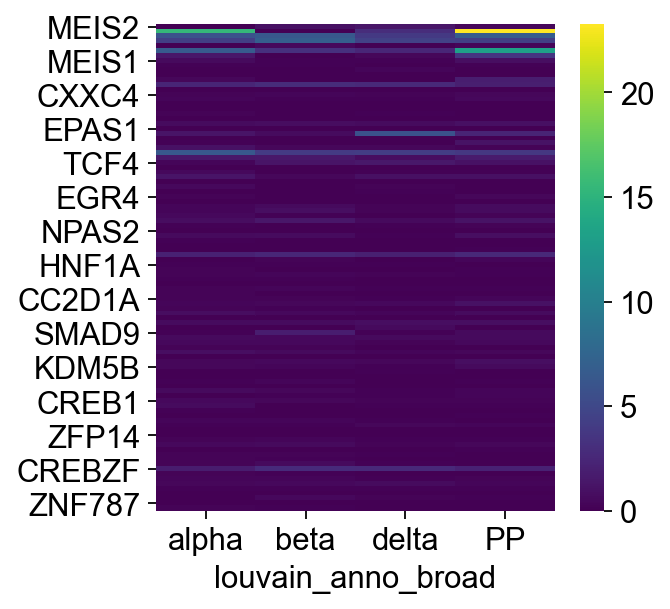

mouse


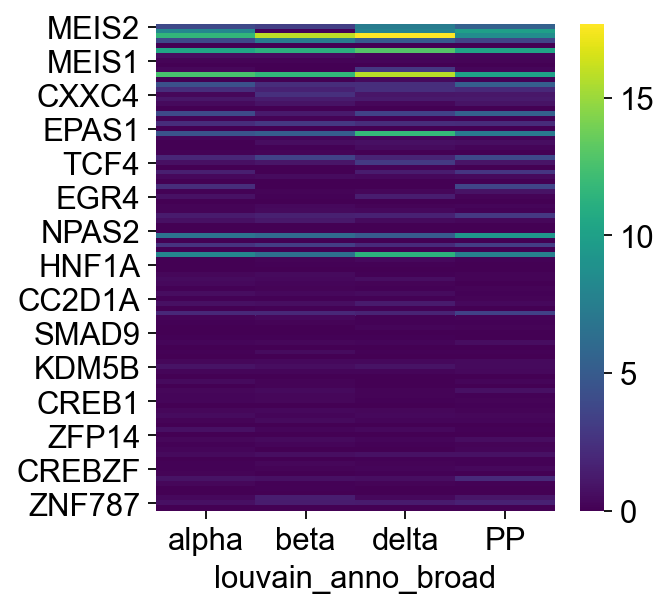

human-pig
across cell types: 0.5087885800255163 1.0037028515592877e-27
wihtin cell type: 0.5993741893171712 4.444760470360057e-11
human-mouse
across cell types: 0.711720981971734 5.061978012662952e-63
wihtin cell type: 0.7146581171606557 6.833822083585688e-17
pig-mouse
across cell types: 0.5241688305544665 1.3065944871451916e-29
wihtin cell type: 0.5927964697556053 8.151733376368442e-11


In [424]:
# TF pattern correlation

df = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])
df_p = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])

for key in df.columns:
    
    print(f'{key}: {len(mk_human_tf[key])} TFs')

    adata_dict = {
        'human': sc.pp.scale(human_comb_endo[:, mk_human_tf[key]], zero_center=False, copy=True),
        'pig': sc.pp.scale(pig_comb_endo[:, mk_human_tf[key]], zero_center=False, copy=True),
        'mouse': sc.pp.scale(mouse_comb_endo[:, mk_human_tf[key]], zero_center=False, copy=True)
    }  
    
    mean_dict = {}
    for k, v in adata_dict.items():
        mean_dict[k] = sc.get.obs_df(
            v,
            keys=['louvain_anno_broad'] + mk_human_tf[key]
        ).groupby('louvain_anno_broad').mean().T.loc[mk_human_tf[key]]      
        
    frac_expressed_dict = {}
    for s in ['human', 'pig', 'mouse']:
        frac_expressed_dict[s] = expression_dict_species[s].loc[mk_human_tf[key]] / expression_dict_species[s].mean(axis=0)

    harmonic_avg = {}
    for s in ['human', 'pig', 'mouse']:
        print(s)        
        harmonic_avg[s] = mean_dict[s] * frac_expressed_dict[s]
        sns.heatmap(harmonic_avg[s], cmap='viridis')
        pl.show()       
        
    for i, combi in enumerate(itertools.combinations(['human', 'pig', 'mouse'], 2)):
        print('-'.join(combi))
        rho, p = pearsonr(harmonic_avg[combi[0]].values.flatten(), harmonic_avg[combi[1]].values.flatten())
        print('across cell types:', rho, p)
        
        df.loc[i, key] = rho
        df_p.loc[i, key] = round(p,4)

        rho, p = pearsonr(harmonic_avg[combi[0]][key], harmonic_avg[combi[1]][key])
        print('wihtin cell type:', rho, p)
        #df.loc[i, key] = [f'rho={rho}, p={p}']

[Text(0.5, 0, 'alpha'),
 Text(1.5, 0, 'beta'),
 Text(2.5, 0, 'delta'),
 Text(3.5, 0, 'PP')]

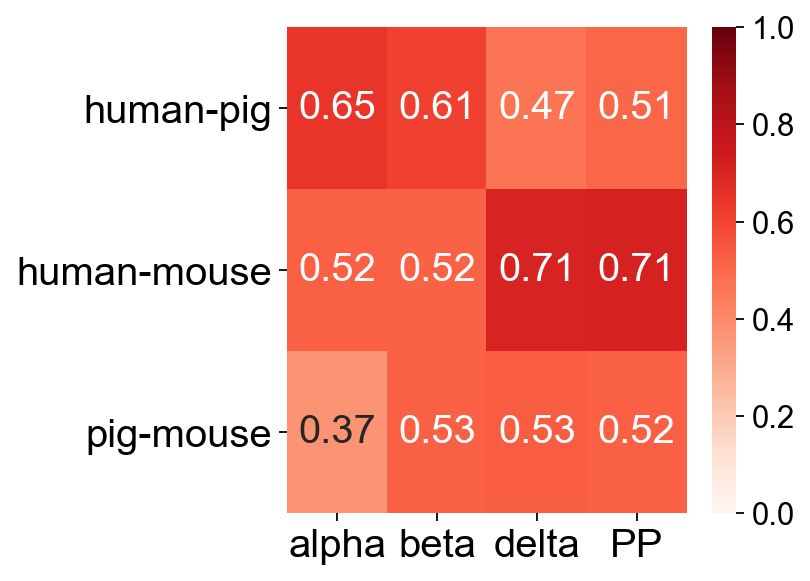

In [425]:
df.index = ['human-pig', 'human-mouse', 'pig-mouse']
ax = sns.heatmap(df.apply(pd.to_numeric), vmin=0, vmax=1, cmap='Reds', annot=df, annot_kws={'fontsize':18})
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

#### Expressed human TFs

In [400]:
tfs = pd.read_csv('./data/TF_names_v_1.01_human.txt', sep='\t', header=None).unstack().tolist()

In [412]:
# TF pattern correlation

df = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])
df_p = pd.DataFrame(columns=['alpha', 'beta', 'delta', 'PP'])

for key in ['alpha', 'beta', 'delta', 'PP']:
    
    consv = conservation_dict[key].loc[(conservation_dict[key]['pig']=='conserved')&(conservation_dict[key]['mouse']=='conserved')].index.tolist()
    consv_tf = [tf for tf in tfs if tf in consv]
    
    print(f'{key}: {len(consv_tf)} TFs')
    
    
    adata_dict = {
        'human': sc.pp.scale(human_comb_endo[:, consv_tf], zero_center=False, copy=True),
        'pig': sc.pp.scale(pig_comb_endo[:, consv_tf], zero_center=False, copy=True),
        'mouse': sc.pp.scale(mouse_comb_endo[:, consv_tf], zero_center=False, copy=True)
    }  
    
    mean_dict = {}
    for k, v in adata_dict.items():
        mean_dict[k] = sc.get.obs_df(
            v,
            keys=['louvain_anno_broad'] + consv_tf
        ).groupby('louvain_anno_broad').mean().T.loc[consv_tf]      
        
    frac_expressed_dict = {}
    for s in ['human', 'pig', 'mouse']:
        frac_expressed_dict[s] = expression_dict_species[s].loc[consv_tf] / expression_dict_species[s].mean(axis=0)

    harmonic_avg = {}
    for s in ['human', 'pig', 'mouse']:
        harmonic_avg[s] = mean_dict[s] * frac_expressed_dict[s]
        
    for i, combi in enumerate(itertools.combinations(['human', 'pig', 'mouse'], 2)):
        print('-'.join(combi))
        rho, p = pearsonr(harmonic_avg[combi[0]].values.flatten(), harmonic_avg[combi[1]].values.flatten())
        print('across cell types:', rho, p)
        df.loc[i, key] = rho
        df_p.loc[i, key] = round(p,4)
        
        rho, p = pearsonr(harmonic_avg[combi[0]][key], harmonic_avg[combi[1]][key])
        print('wihtin cell type:', rho, p)


alpha: 277 TFs
human-pig
across cell types: 0.7001369259378879 5.375071389952845e-164
wihtin cell type: 0.6330675797499206 1.9804941029337893e-32
human-mouse
across cell types: 0.5902541328111283 5.492268289020444e-105
wihtin cell type: 0.5503825241730139 2.4488339172146063e-23
pig-mouse
across cell types: 0.6259316206528676 1.4597964057588597e-121
wihtin cell type: 0.6363744276395974 7.494515586690709e-33
beta: 318 TFs
human-pig
across cell types: 0.7081264405783823 3.534938494667536e-194
wihtin cell type: 0.752000140888654 3.7688782459090903e-59
human-mouse
across cell types: 0.6164522601308956 5.275520428276385e-134
wihtin cell type: 0.6240895643397316 9.865053889789328e-36
pig-mouse
across cell types: 0.6531892738167763 1.342902217067978e-155
wihtin cell type: 0.7132056790319841 1.08461864332046e-50
delta: 264 TFs
human-pig
across cell types: 0.6909943828786492 9.855834850591756e-151
wihtin cell type: 0.7349661620984778 4.2103107257228856e-46
human-mouse
across cell types: 0.601634

### PCA representation and correlation of endocrine profiles

In [65]:
adata_comb_endo = sc.pp.scale(
    human_comb_endo, copy=True, zero_center=False).concatenate(
    sc.pp.scale(pig_comb_endo, copy=True, zero_center=False), 
    sc.pp.scale(mouse_comb_endo, copy=True, zero_center=False), 
    batch_categories=['human', 'pig', 'mouse'])

In [67]:
adata_comb_endo.obs.louvain_anno_broad.value_counts()

beta     36605
alpha    14178
delta     4458
PP         300
Name: louvain_anno_broad, dtype: int64

In [68]:
# subset beta, alpha, delta to equal representation
x_beta = sc.pp.subsample(adata_comb_endo[adata_comb_endo.obs.louvain_anno_broad.isin(['beta'])].copy(),n_obs=2000, copy=True).obs_names
x_alpha = sc.pp.subsample(adata_comb_endo[adata_comb_endo.obs.louvain_anno_broad.isin(['alpha'])].copy(),n_obs=2000, copy=True).obs_names
x_delta = sc.pp.subsample(adata_comb_endo[adata_comb_endo.obs.louvain_anno_broad.isin(['delta'])].copy(),n_obs=2000, copy=True).obs_names
x_pp= adata_comb_endo[adata_comb_endo.obs.louvain_anno_broad.isin(['PP'])].copy().obs_names

In [69]:
adata_comb_endo_sub = adata_comb_endo[list(x_beta)+list(x_alpha)+list(x_delta)+list(x_pp)].copy()

In [71]:
adata_comb_endo_sub.obs.louvain_anno_broad.value_counts()

delta    2000
beta     2000
alpha    2000
PP        300
Name: louvain_anno_broad, dtype: int64

In [72]:
sc.pp.filter_genes(adata_comb_endo_sub, min_cells=20)

filtered out 347 genes that are detected in less than 20 cells


In [73]:
sc.pp.highly_variable_genes(adata_comb_endo_sub, n_top_genes=4000, flavor='cell_ranger')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [152]:
sc.pp.pca(adata_comb_endo_sub)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)


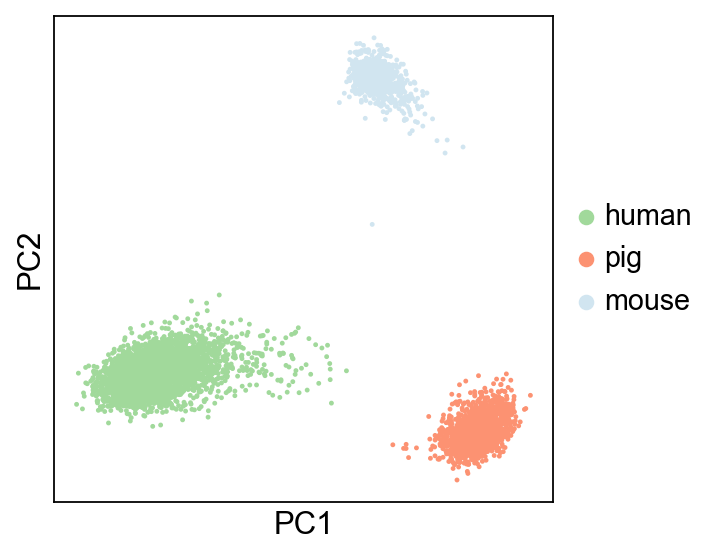

In [156]:
sc.set_figure_params()
sc.pl.pca(adata_comb_endo_sub, color='batch', components=['1,2'], title=[''], palette=['#a1d99b', '#fc9272', '#d1e5f0'])

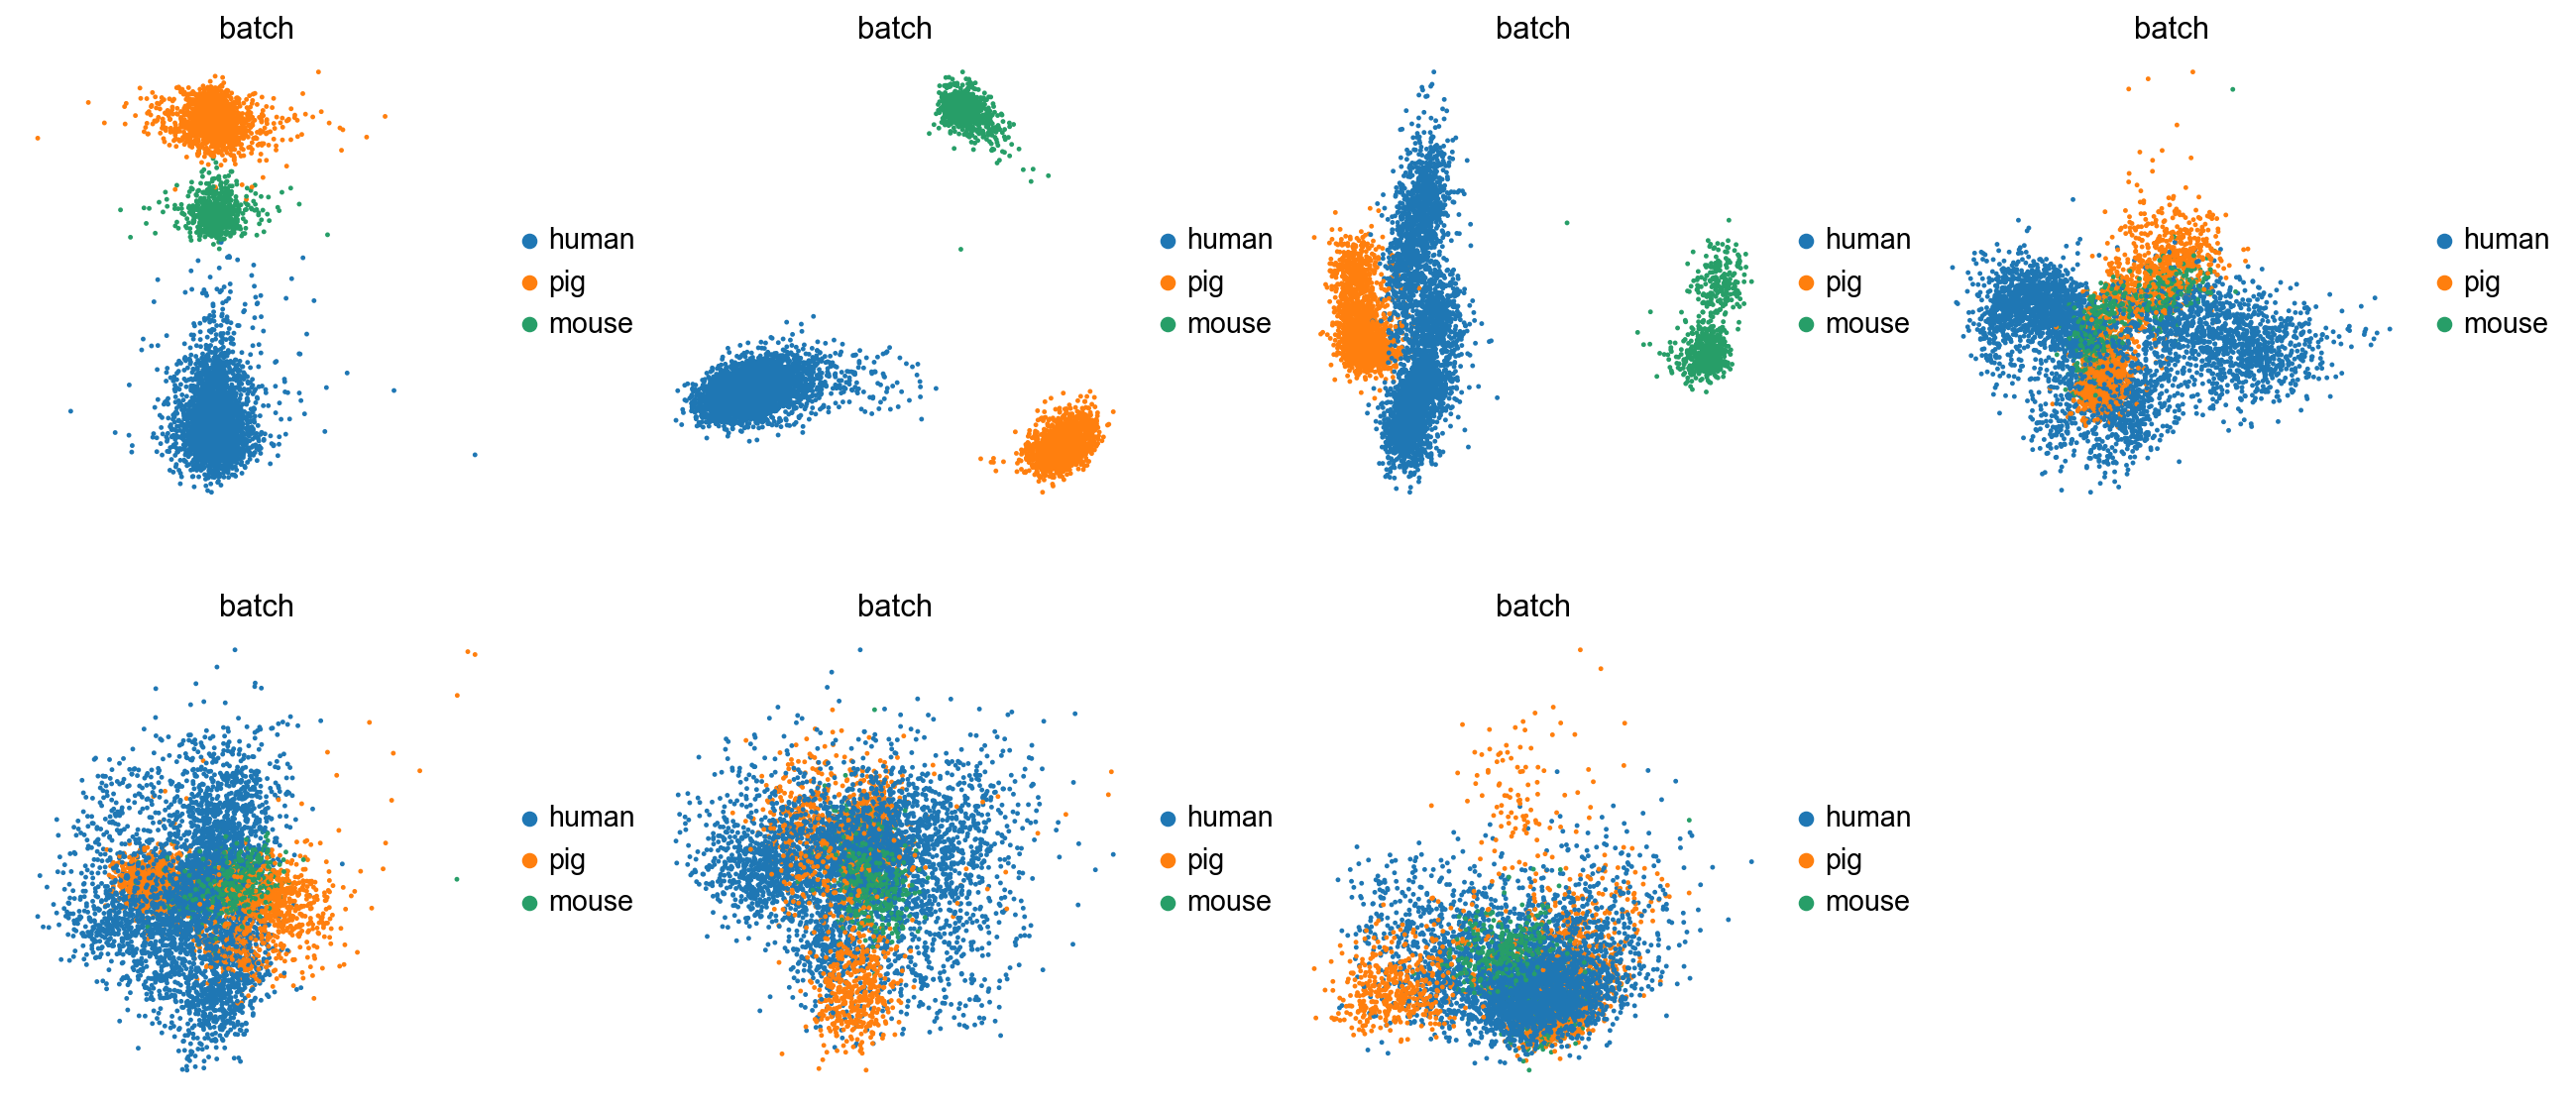

In [77]:
sc.pl.pca(adata_comb_endo_sub, color='batch', components=['0,1', '1,2', '2,3', '3,4', '4,5', '5,6', '6,7'])

In [78]:
#removing PC1 and 2 that show strong species effect
adata_comb_endo_sub.obsm['X_pca'] = np.delete(adata_comb_endo_sub.obsm['X_pca'],0,axis=1)
adata_comb_endo_sub.obsm['X_pca'] = np.delete(adata_comb_endo_sub.obsm['X_pca'],0,axis=1)

In [79]:
adata_comb_endo_sub.obs['louvain_species'] = ['_'.join([a,b]) for a,b in zip(adata_comb_endo_sub.obs.louvain_anno_broad,adata_comb_endo_sub.obs.batch)]

In [80]:
%%time
genedf = sc.get.obs_df(
        adata_comb_endo_sub,
        keys=['louvain_species'],
        obsm_keys=[('X_pca', i) for i in range(0,48)]
    )
grouped = genedf.groupby('louvain_species')
mean_df = grouped.mean()

CPU times: user 20.4 ms, sys: 4.29 ms, total: 24.7 ms
Wall time: 26.5 ms


In [117]:
df_corr = mean_df.T.corr(method='pearson')

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Use the colorbar set_ticks() method instead.
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Use the colorbar set_ticks() method instead.


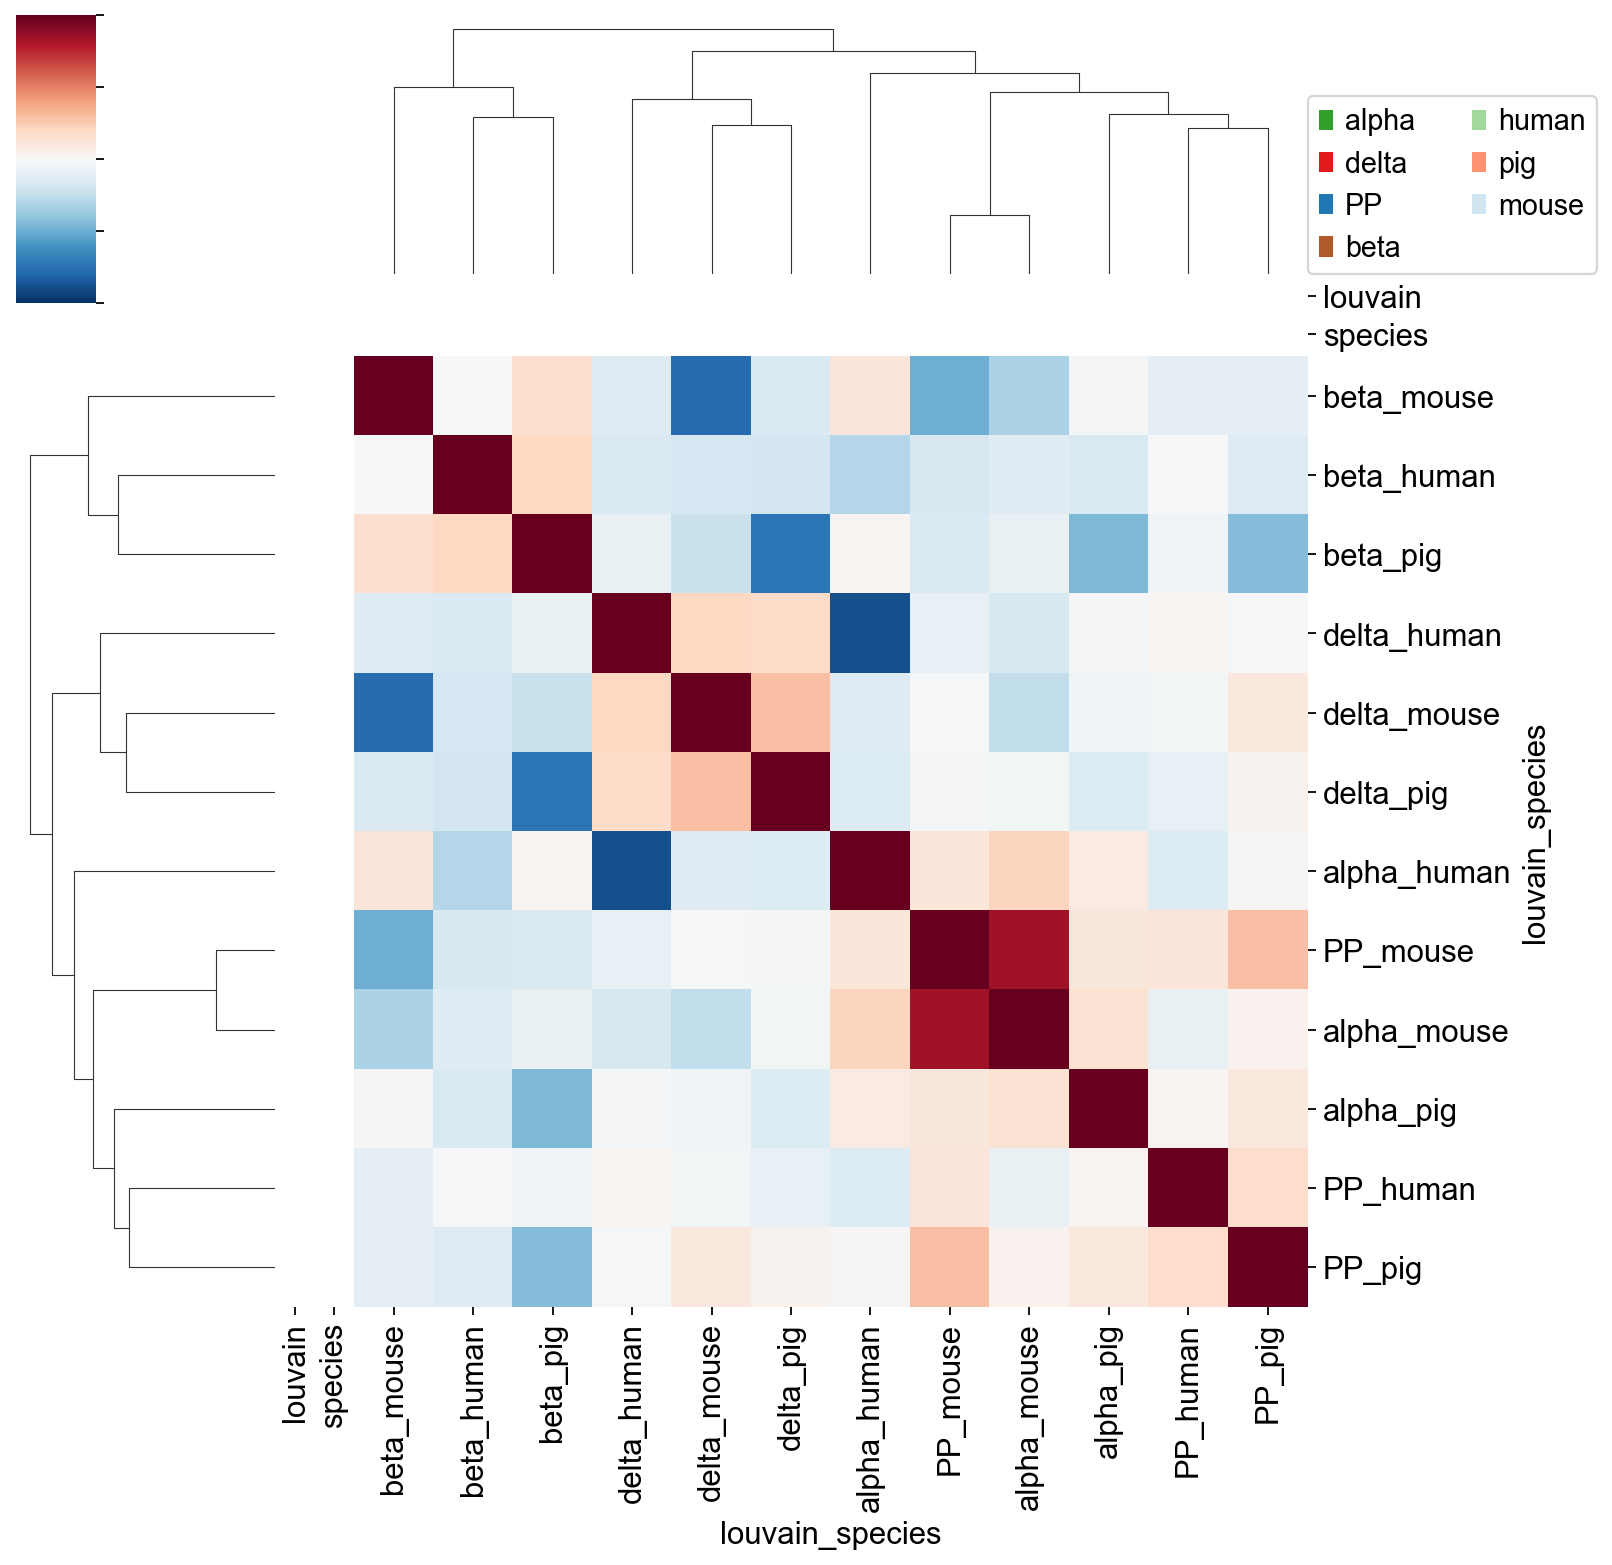

In [120]:
# set row colors
cols = pd.DataFrame(index = df_corr.index)

col_dict_1 = dict(zip(set(adata_comb_endo.obs.louvain_anno_broad.cat.categories), human_comb_endo.uns['louvain_anno_broad_colors']))
cols['louvain'] = pd.DataFrame([g.split('_')[1] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_1)

col_dict_2 = dict(zip(set(adata_comb_endo.obs.batch.cat.categories), ['#a1d99b', '#fc9272', '#d1e5f0']))
cols['species'] = pd.DataFrame([g.split('_')[0] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_2)

g = sns.clustermap(df_corr, col_colors=cols, row_colors=cols, vmin=-1,vmax=1, cmap='RdBu_r')

# add legend for colors
for label in col_dict_1.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_1[label],
                            label=label, linewidth=0)
for label in col_dict_2.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_2[label],
                            label=label, linewidth=0)
g.cax.set_xticklabels([])
g.cax.set_yticklabels([])
g.cax.set_xticks([])
g.cax.set_yticks([])

g.ax_col_dendrogram.legend(loc=(1,0), ncol=2)

In [148]:
for key in ['alpha', 'beta', 'delta', 'PP', 'human', 'pig', 'mouse']:
    df_sub = df_corr.loc[[x for x in df_corr.index if key in x], [x for x in df_corr.columns if key in x]]
    avg = np.round(np.array(df_sub)[np.triu_indices(3, k = 1)].mean(), 2)
    print(f'average correlation {key}: {avg}')

average correlation alpha: 0.15
average correlation beta: 0.12
average correlation delta: 0.23
average correlation PP: 0.2
average correlation human: -0.15
average correlation pig: -0.26
average correlation mouse: 0.02


## Hormone receptor and ion channel expression  in mature endocrine cells

In [584]:
human_comb_endo_mat = human_comb_endo[human_comb_endo.obs.louvain_anno_fine.isin(['delta', 'beta_mature', 'alpha_mature', 'PP'])].copy()
pig_comb_endo_mat = pig_comb_endo[pig_comb_endo.obs.louvain_anno_fine.isin(['delta', 'beta_mature', 'alpha_mature', 'PP'])].copy()
mouse_comb_endo_mat = mouse_comb_endo[mouse_comb_endo.obs.louvain_anno_fine.isin(['delta', 'beta_mature', 'alpha_mature', 'PP'])].copy()

### Hormone receptors

In [657]:
hormone_receptors = {
    # adrenal gland
    '(nor)epinephrine' : ['ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'ADRB3'],
    'dopamine' : ['DRD1', 'DRD2','DRD3', 'DRD4', 'DRD5'],
    
    #brain
    'gonadotrophin' : ['GNRHR1', 'GNRHR2'],
    'kisspeptin' : ['KISS1R'],
    'oxytocin' : ['OXTR'],
    'vasopressin' : ['AVPR1A', 'AVPR1B', 'AVPR2', 'CUL5', 'VACM1'],
    'corticotropin' : ['CRHR1'],
    'opioid':['OPRD1', 'OPRK1', 'OPRM1', 'OPRL1', 'OGFR'],
    'orexin' : ['HCRTR1', 'HCRTR2'],
    
    # pituitary gland
    'melanocortin' : ['MC1R', 'MC3R', 'MC4R', 'MC5R'],
    'ACTH' : ['MC2R'],
    'corticoid' : ['NR3C2', 'NR3C1'],
    'LH' :['LHCGR'], #luteinizing
    'FSH' : ['FSHR'], #follicle-stimulating
    'GH' : ['GHR'], #growth hormone
    'GH-releasing' : ['GHRHR'], #growth hormone-releasing
    'thyrotropin' : ['TSHR', 'TRHR'],
    
    # pineal gland 
    'melatonin' : ['MTNR1A', 'MTNR1B'],
    
    #ovaries
    'amh' : ['AMHR1', 'AMHR2'],
    'estrogen' : ['ESRRG', 'ESR1', 'ESRRA', 'ESR2'],
    'progesterone' : ['PGR'],
    'relaxin' : ['RXFP1', 'RXFP2', 'RXFP3', 'RXFP4'],
    
    #thyroid
    'thyroid' : ['THRA', 'THRB'],
    'calcitonin':['RAMP1', 'RAMP2', 'RAMP3', 'CALCR', 'CALCRL'],
    
    #parathyroid gland
    'parathyroid' : ['PTH1R', 'PTH2R'],
    
    #heart
    'natriuretic' : ['NPRL3', 'NPR3', 'NPR1', 'NPR2', 'NPRL2'],
    
    # liver
    'angiotensin' : ['AGTR1', 'ATGR2'],
    'hepcidin' : ['SLC40A1'],
    
    #kidney
    'epo' : ['EPOR'],
    'vitaminD ': ['VDR'],
    
    # intestinal
    'incretin' : ['GHSR', 'GIPR', 'GLP1R', 'GLP2R', 'SCTR', 'CCKAR', 'CCKBR', 'NPY1R', 'NPY2R', 'NPY5R'],
    'insl5/relaxin' : ['RXFP1', 'RXFP2', 'RXFP3', 'RXFP4'],
    'motilin' : ['MLNR'],
    'vip' : ['ADCYAP1R1', 'VIPR1', 'VIPR2'],
    'guanylin' : ['GUCY2C'],
    
    #pancreas
    'glucagon' : ['GCGR'],
    'ppy' : ['PPYR1'],
    'insulin' : ['INSR', 'INSRR', 'IGF1R', 'IGF2R', 'IGFLR1'],
    'somatostatin' : ['SSTR1', 'SSTR2', 'SSTR3', 'SSTR4', 'SSTR5'],
    
    #fat
    'adiponectin' : ['ADIPOR1', 'ADIPOR2'],
    'leptin' : ['LEPR'],
    
    #blood
    'leukotirene' : ['TBXA2R'],
    
    #bone
    'osteocalcin' : ['GPRC6A'],
    
    # mulitple
    'serotonin' : ['HTR1A', 'HTR1B', 'HTR1D', 'HTR1F', 'HTR2A', 'HTR2B', 'HTR2C' 'HTR3A', 'HTR3B', 'HTR3D', 'HTR3E', 'HTR4', 'HTR5A', 'HTR5B', 'HTR6', 'HTR7'],
    'galanin' : ['GALR1', 'GALR2', 'GALR3'],
    'prostanoid' : ['PTGER3', 'PTGFR', 'PTGER4', 'PTGDR2', 'PTGDR', 'PTGER2', 'PTGER1', 'PTGIR'],
    'prolactin' : ['PRLR'],
    'androgen' : ['AR'],
    'thrombopoietin' : ['MPL'],
    'RA' : ['RARA', 'RARB', 'RARG'],
    'endothelin' : ['EDNRB', 'EDNRA']}

In [658]:
receptors_sub={}
receptors_genes = []
for key in hormone_receptors.keys():
    genes = [gene for gene in hormone_receptors[key] if gene in human_comb_endo.var_names]

    if len(genes)>0:
        receptors_sub[key] = genes
        receptors_genes = receptors_genes + genes

#### Correlation of expression pattern

In [742]:
receptors_genes_det = [gene for gene in receptors_genes if np.any([
    np.any(expression_dict_species['human'].loc[gene]>0.05), 
    np.any(expression_dict_species['pig'].loc[gene]>0.05), 
    np.any(expression_dict_species['mouse'].loc[gene]>0.05)
])
]

In [768]:
df = pd.DataFrame(columns=['beta'])
df_p = pd.DataFrame(columns=['beta'])

for key in ['beta']:

    adata_dict = {
        'human': sc.pp.scale(human_comb_endo_mat[:, receptors_genes_det], zero_center=False, copy=True),
        'pig': sc.pp.scale(pig_comb_endo_mat[:, receptors_genes_det], zero_center=False, copy=True),
        'mouse': sc.pp.scale(mouse_comb_endo_mat[:, receptors_genes_det], zero_center=False, copy=True)
    }  
    
    mean_dict = {}
    for k, v in adata_dict.items():
        mean_dict[k] = sc.get.obs_df(
            v,
            keys=['louvain_anno_broad'] + receptors_genes_det
        ).groupby('louvain_anno_broad').mean().T.loc[receptors_genes_det]      
        
    frac_expressed_dict = {}
    for s in ['human', 'pig', 'mouse']:
        frac_expressed_dict[s] = expression_dict_species[s].loc[receptors_genes_det] / expression_dict_species[s].mean(axis=0)

    harmonic_avg = {}
    for s in ['human', 'pig', 'mouse']:
        print(s)        
        harmonic_avg[s] = mean_dict[s] * frac_expressed_dict[s]
               
        
    for i, combi in enumerate(itertools.combinations(['human', 'pig', 'mouse'], 2)):
        print('-'.join(combi))
        rho, p = pearsonr(harmonic_avg[combi[0]].values.flatten(), harmonic_avg[combi[1]].values.flatten())
        print('across cell types:', rho, p)
        
        df.loc[i, key] = rho
        df_p.loc[i, key] = round(p,4)

human
pig
mouse
human-pig
across cell types: 0.5444145475505827 1.3718689269565578e-15
human-mouse
across cell types: 0.09089837921421588 0.21976809215497464
pig-mouse
across cell types: 0.025406955710129124 0.7320925098412709


<AxesSubplot:>

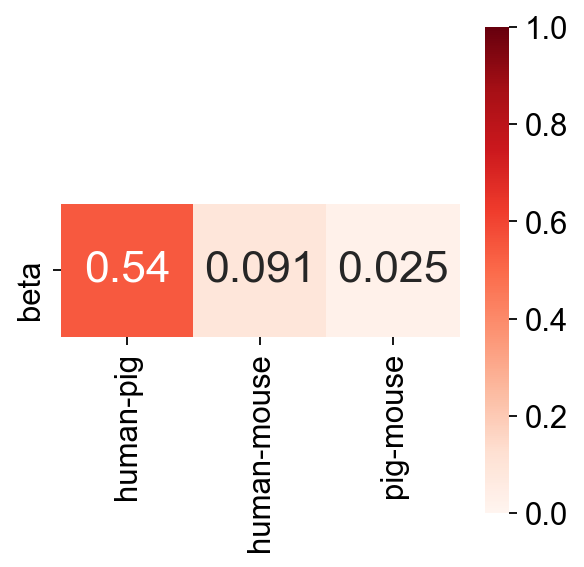

In [769]:
df.index = ['human-pig', 'human-mouse', 'pig-mouse']

sns.heatmap(df.apply(pd.to_numeric).T, vmin=0, vmax=1, cmap='Reds', annot=df.T, square=True, annot_kws={'fontsize':20})

#### Differentially expressed receptors

In [699]:
hormone_receptors_diff = {
    '(nor)epinephrine' : ['ADRB2'],    
    'kisspeptin' : ['KISS1R'],
    'oxytocin' : ['OXTR'],
    'GH' : ['GHR'], 
    'estrogen' : ['ESRRG', 'ESR1'],
    'progesterone' : ['PGR'],
    
    #thyroid
    'thyroid' : ['THRA', 'THRB'],
    'calcitonin':['RAMP1', 'RAMP2', 'RAMP3'],
    
    #heart
    'natriuretic' : ['NPR1', 'NPR2'],
    
    # liver
    'angiotensin' : ['AGTR1'],
    'hepcidin' : ['SLC40A1'],
    'vitaminD ': ['VDR'],
    
    # intestinal
    'incretin' : ['GHSR', 'GIPR', 'SCTR', 'CCKBR'],
    'vip' : ['VIPR1'],
    'guanylin' : ['GUCY2C'],
    
    #pancreas
    'insulin' : ['INSR', 'IGF1R', 'IGF2R'],
    'somatostatin' : ['SSTR2', 'SSTR5'],
    
    #fat
    'leptin' : ['LEPR'],
    
    # mulitple
    'prostanoid' : ['PTGER3', 'PTGER4', 'PTGFR',  'PTGDR'],
    'prolactin' : ['PRLR']
}

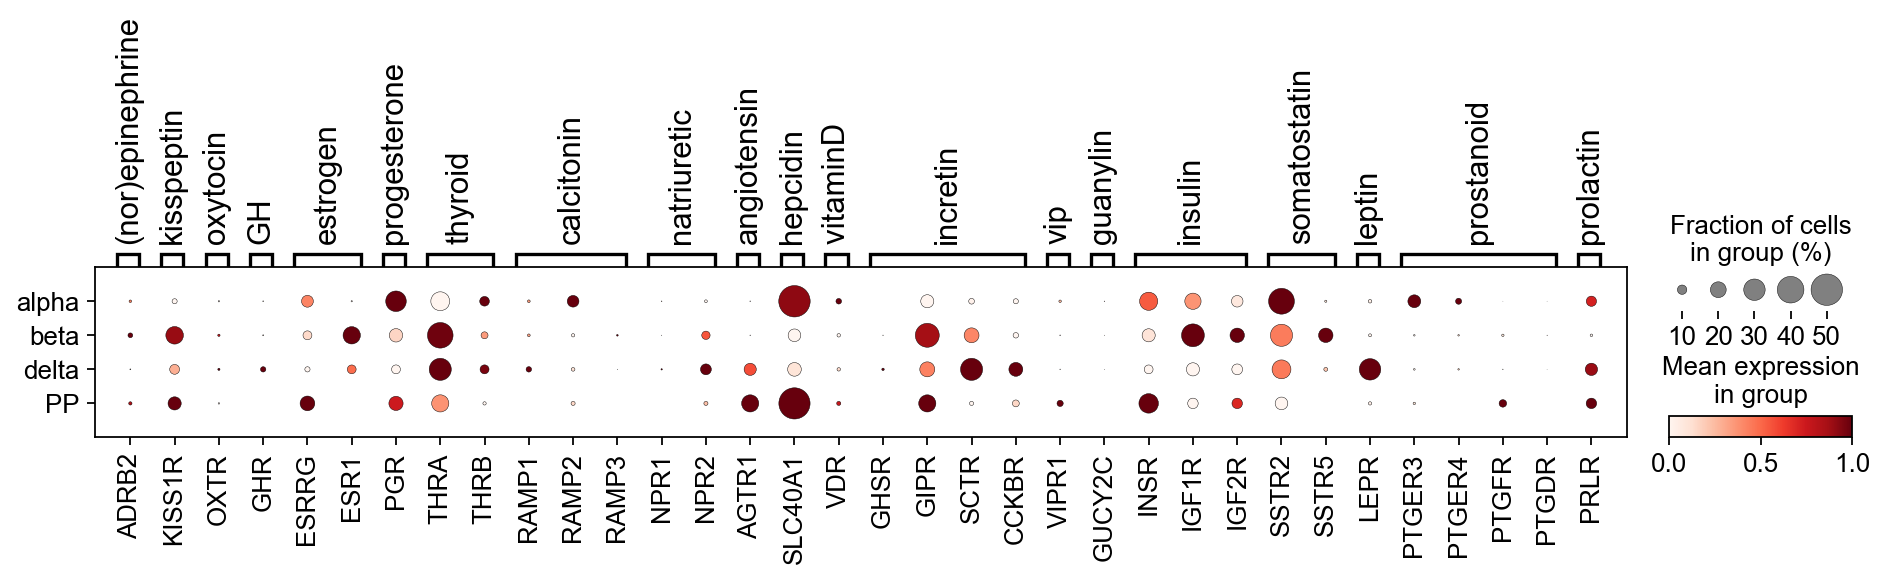

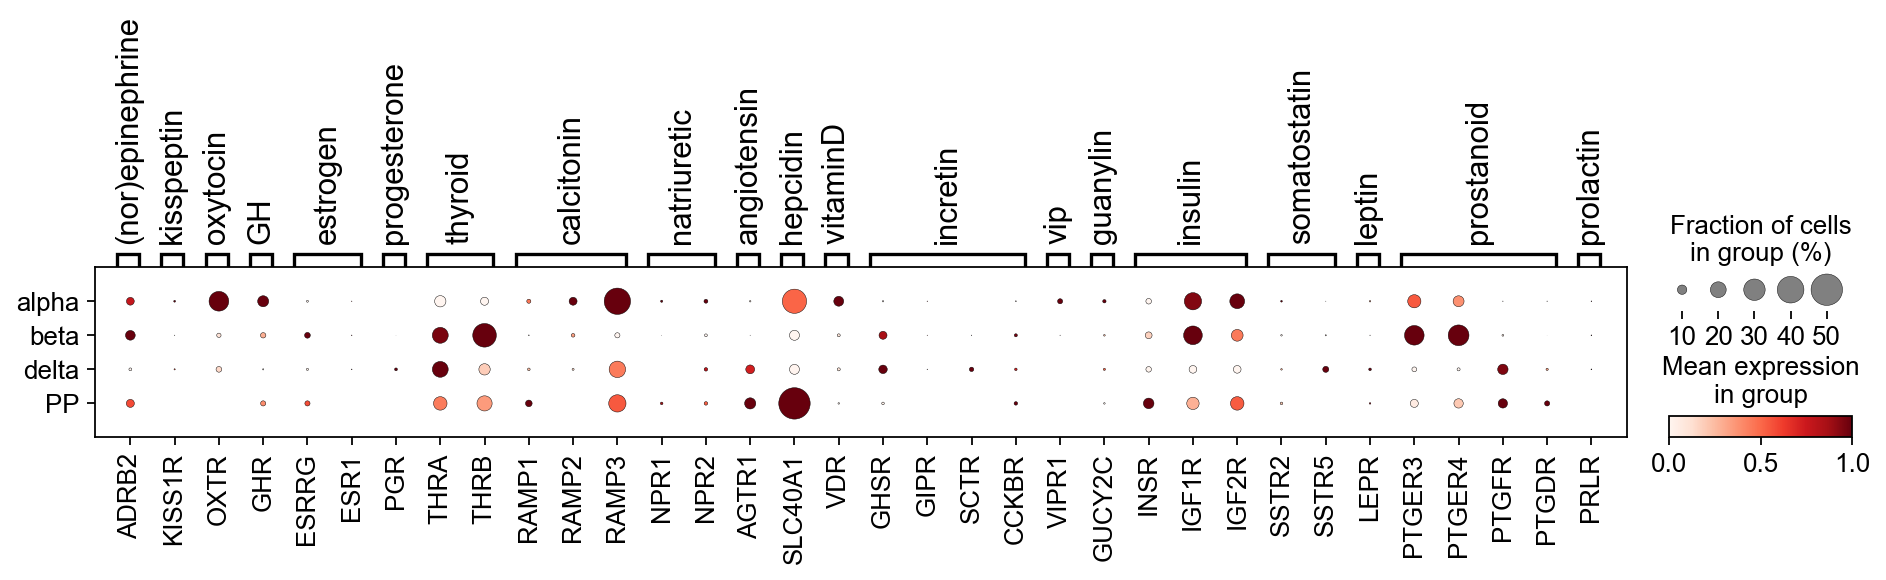

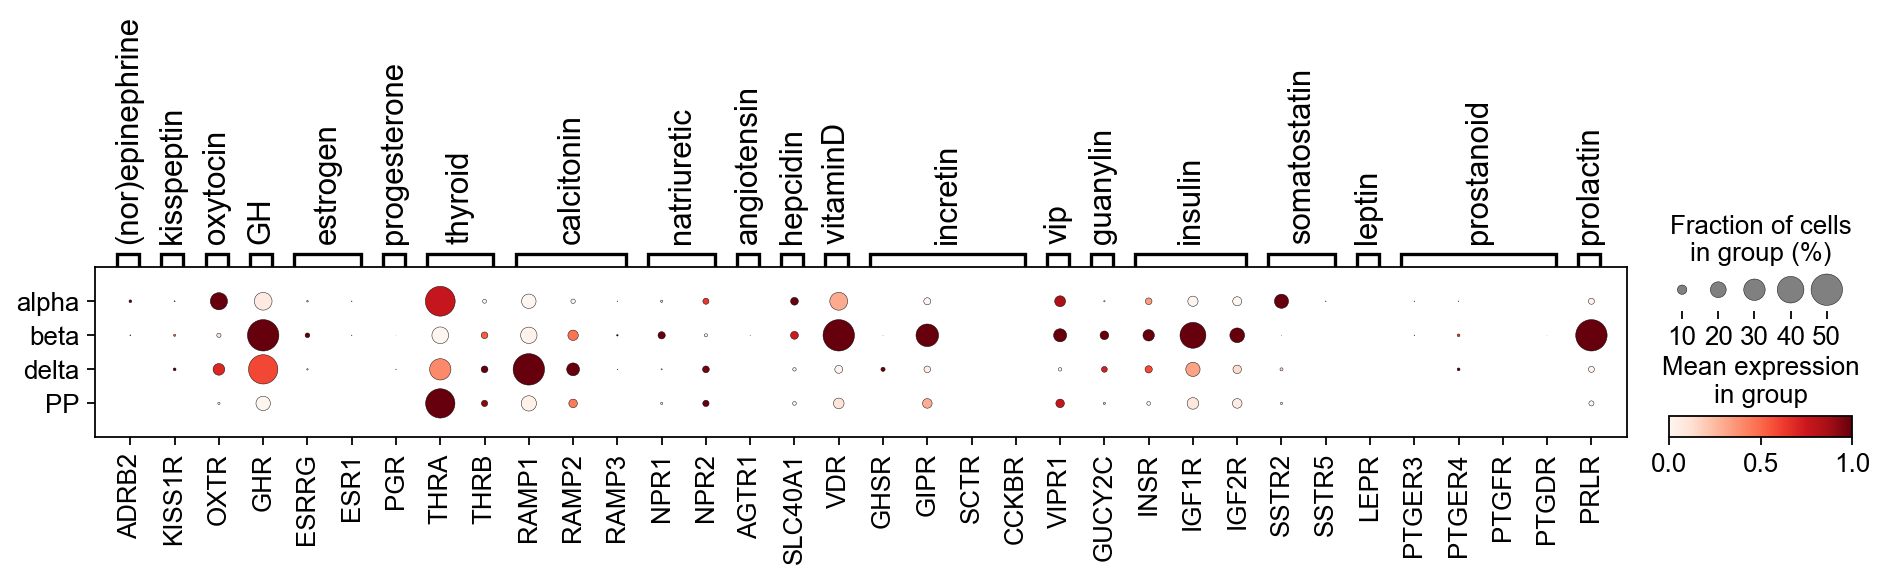

In [700]:
sc.pl.dotplot(human_comb_endo_mat, groupby='louvain_anno_broad', var_names=hormone_receptors_diff, dot_max=0.5, standard_scale='var')
sc.pl.dotplot(pig_comb_endo_mat, groupby='louvain_anno_broad', var_names=hormone_receptors_diff, dot_max=0.5, standard_scale='var')
sc.pl.dotplot(mouse_comb_endo_mat, groupby='louvain_anno_broad', var_names=hormone_receptors_diff, dot_max=0.5, standard_scale='var')

### Ion channels

In [720]:
ion_genes = [gene for gene in human_comb_endo_mat.var_names if (gene.startswith('CACN')) | (gene.startswith('KCN')) | (gene.startswith('SCN')) | (gene.startswith('TRPM'))]

In [739]:
ion_genes_det = [gene for gene in ion_genes if np.any([
    np.any(expression_dict_species['human'].loc[gene]>0.05), 
    np.any(expression_dict_species['pig'].loc[gene]>0.05), 
    np.any(expression_dict_species['mouse'].loc[gene]>0.05)
])
]

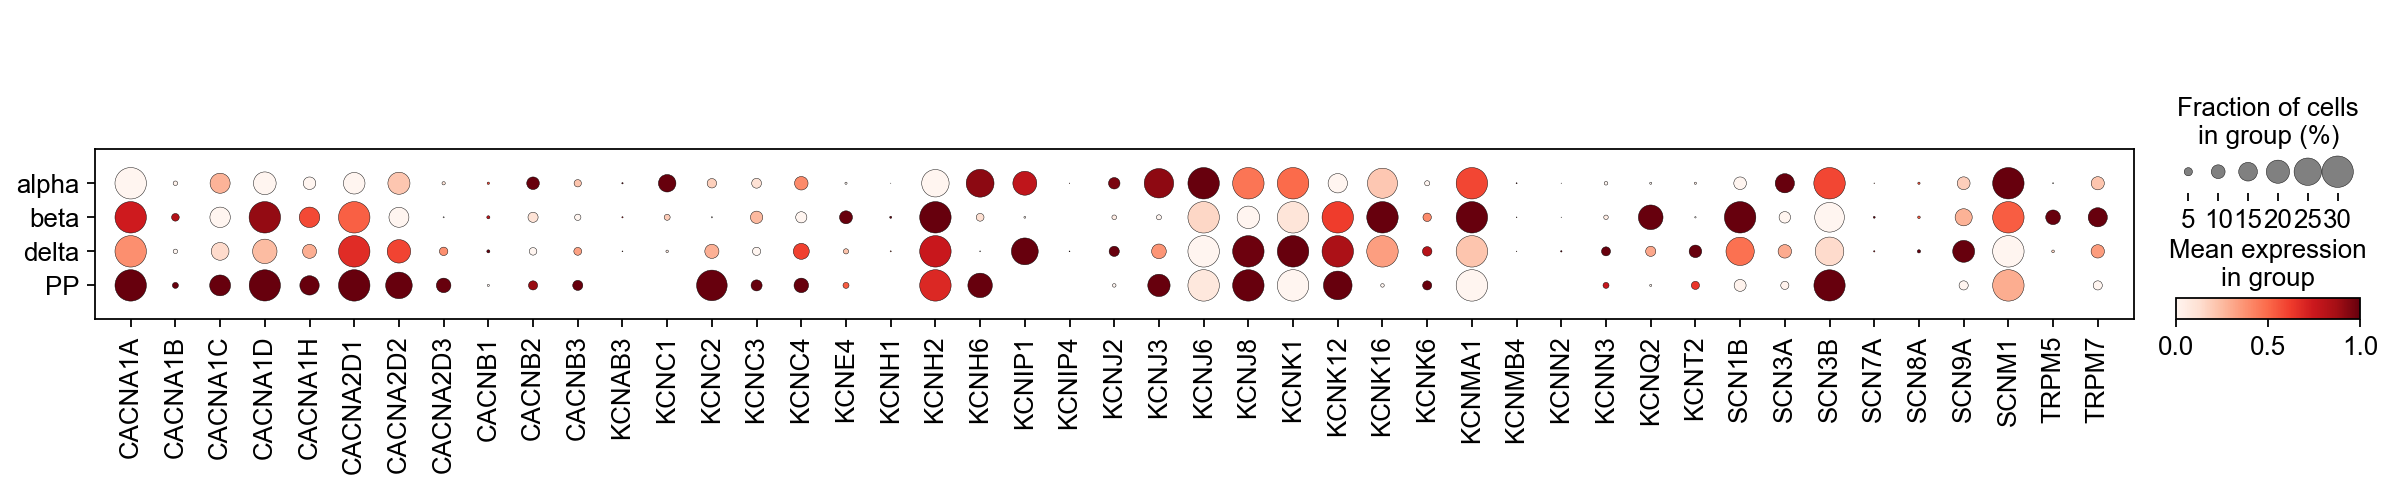

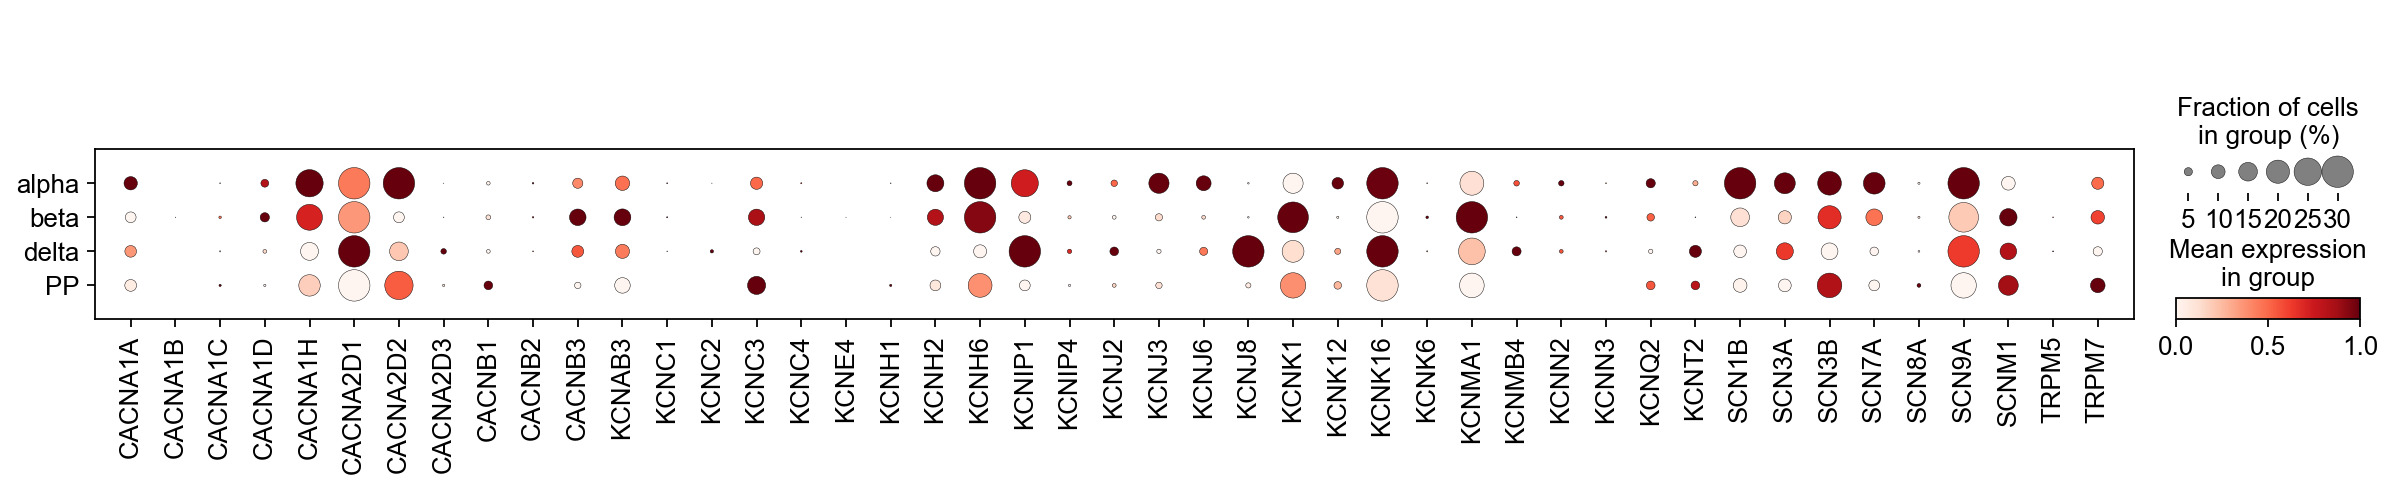

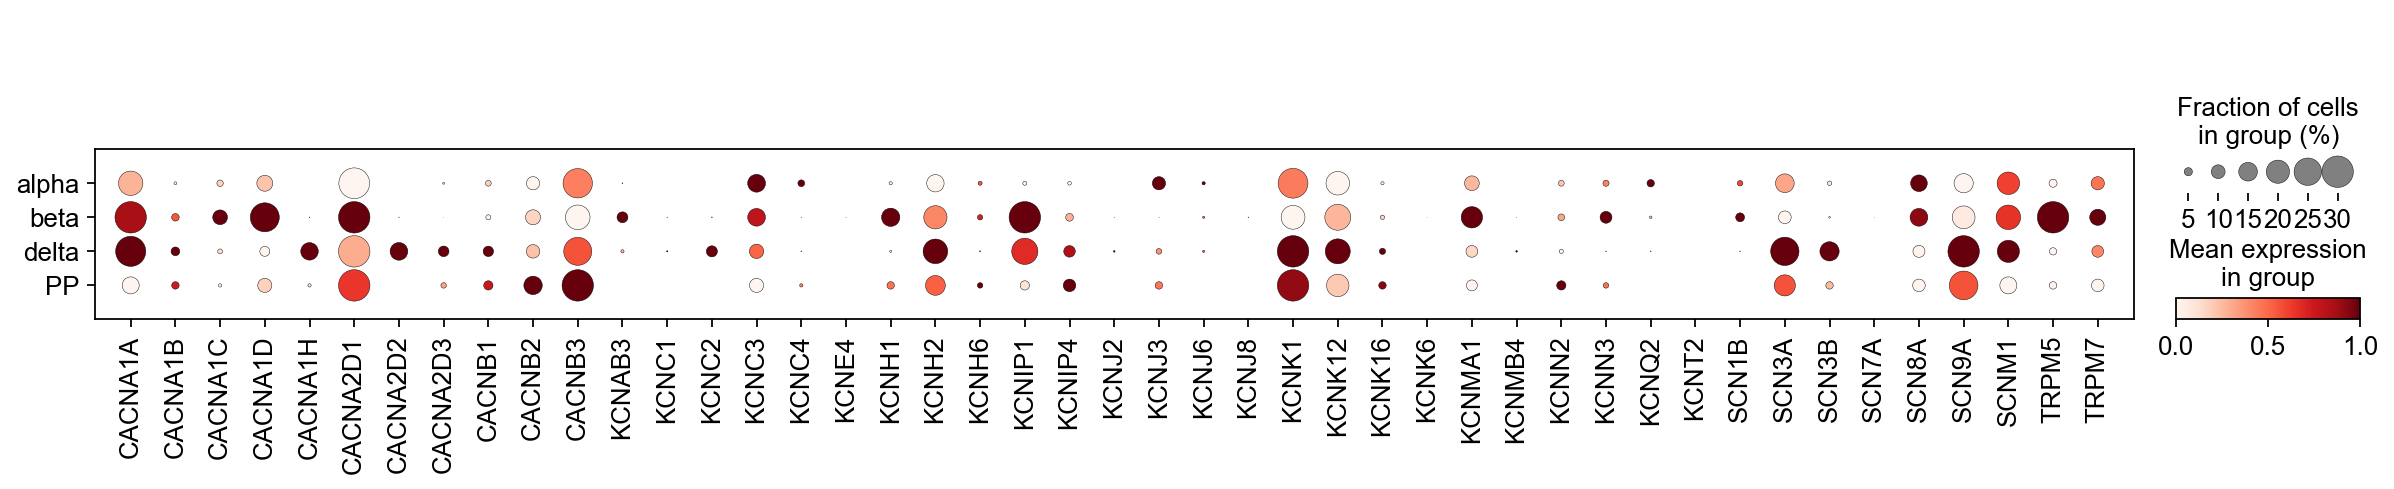

In [760]:
genes = sorted(ion_genes_det)
sc.pl.dotplot(human_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.3, standard_scale='var')
sc.pl.dotplot(pig_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.3, standard_scale='var')
sc.pl.dotplot(mouse_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.3, standard_scale='var')

#### Correlation of expression pattern

In [763]:
df = pd.DataFrame(columns=['beta'])
df_p = pd.DataFrame(columns=['beta'])

for key in ['beta']:

    adata_dict = {
        'human': sc.pp.scale(human_comb_endo_mat[:, ion_genes_det], zero_center=False, copy=True),
        'pig': sc.pp.scale(pig_comb_endo_mat[:, ion_genes_det], zero_center=False, copy=True),
        'mouse': sc.pp.scale(mouse_comb_endo_mat[:, ion_genes_det], zero_center=False, copy=True)
    }  
    
    mean_dict = {}
    for k, v in adata_dict.items():
        mean_dict[k] = sc.get.obs_df(
            v,
            keys=['louvain_anno_broad'] + ion_genes_det
        ).groupby('louvain_anno_broad').mean().T.loc[ion_genes_det]      
        
    frac_expressed_dict = {}
    for s in ['human', 'pig', 'mouse']:
        frac_expressed_dict[s] = expression_dict_species[s].loc[ion_genes_det] / expression_dict_species[s].mean(axis=0)

    harmonic_avg = {}
    for s in ['human', 'pig', 'mouse']:
        print(s)        
        harmonic_avg[s] = mean_dict[s] * frac_expressed_dict[s]
                   
    for i, combi in enumerate(itertools.combinations(['human', 'pig', 'mouse'], 2)):
        print('-'.join(combi))
        rho, p = pearsonr(harmonic_avg[combi[0]].values.flatten(), harmonic_avg[combi[1]].values.flatten())
        print('across cell types:', rho, p)
        
        df.loc[i, key] = rho
        df_p.loc[i, key] = round(p,4)

human
pig
mouse
human-pig
across cell types: 0.2594293016912814 0.0004368367852861731
human-mouse
across cell types: 0.09821978561065234 0.18960439681159813
pig-mouse
across cell types: 0.09422058432101754 0.20835708674462866


<AxesSubplot:>

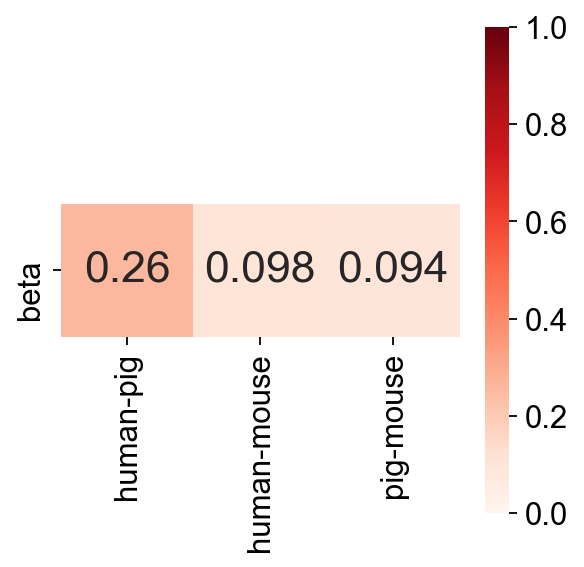

In [767]:
df.index = ['human-pig', 'human-mouse', 'pig-mouse']

sns.heatmap(df.apply(pd.to_numeric).T, vmin=0, vmax=1, cmap='Reds', annot=df.T, square=True, annot_kws={'fontsize':20})

#### Differentially expressed ion channels

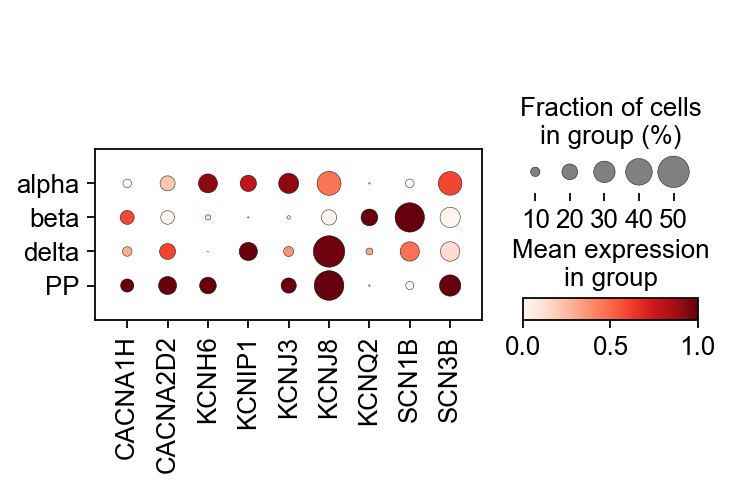

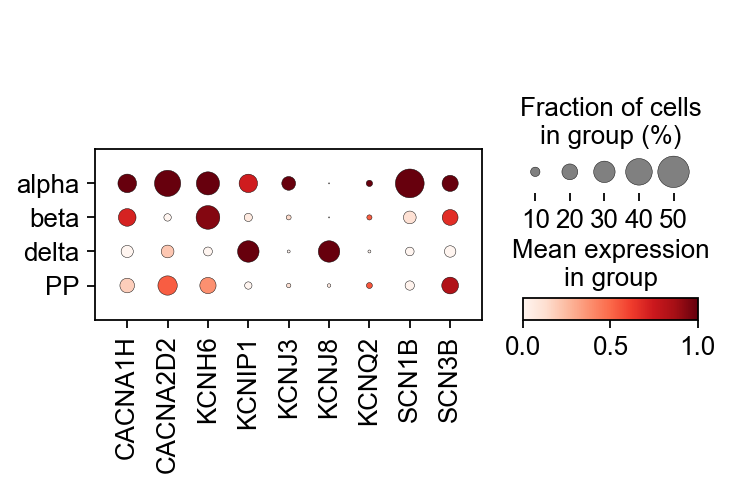

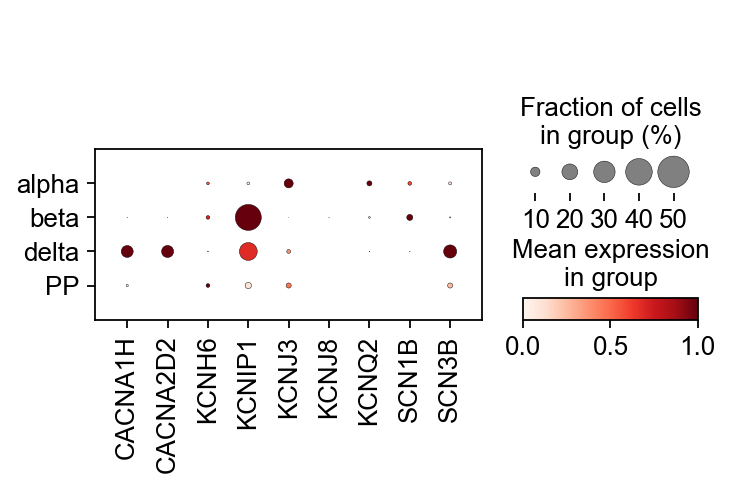

In [776]:
genes = ['CACNA1H', 'CACNA2D2', 'KCNH6', 'KCNIP1', 'KCNJ3', 'KCNJ8', 'KCNQ2', 'SCN1B', 'SCN3B']
sc.pl.dotplot(human_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, standard_scale='var')
sc.pl.dotplot(pig_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, standard_scale='var')
sc.pl.dotplot(mouse_comb_endo_mat, groupby='louvain_anno_broad', var_names=genes, dot_max=0.5, standard_scale='var')

### Validation of enrichment in Benner et al

In [778]:
df = pd.read_excel('./data/12864_2014_6324_MOESM9_ESM.xlsx', skiprows=3)

In [779]:
df['gene name'] = df['gene name'].str.upper()

In [780]:
len(df['gene name'])

1540

In [781]:
df = df.loc[[gene in human_comb_endo.var_names for gene in df['gene name']]]

In [782]:
len(df['gene name'])

883

In [690]:
df.loc[[gene in receptors_genes for gene in df['gene name']]].sort_values(by='enriched in')

gene name accession number  beta cells (RPKM)  beta cells (RPKM).1  \
412       ESR1     XM_006512432           0.009561            12.009001   
477        PGR     XM_006509848           0.011975             6.934371   
508      SSTR2     NM_001042606           0.124502            24.547925   
701       EPOR     XM_006509997           0.195086            13.405618   
706       SCTR     XM_006529683           0.023279            12.347520   
1236      LEPR     NM_001122899           0.000000             3.474107   
1326     SSTR5     XM_006523947           0.054592            11.694895   
1384     ADRB2        NM_007420           0.104884             2.521961   
120        GHR     XM_006519963          73.266641             0.587563   
172      VIPR1     XM_006512068          27.749028             0.341027   
238       PRLR     XM_006520034          65.299139             1.690265   
309        VDR        NM_009504          73.178488             2.808011   
322       NPR1     XM_006501114          10.782957             0.356922   
387     GUCY2C     NM_001127318           8.127368             0.345392   
602      RAMP2        NM_019444          21.270546             1.302080   
845       RARG     XM_006520649           6.453356             0.645360   

      enrichment    status enriched in  adj. p value  
412    10.279740    unique       human  4.195275e-31  
477     9.165664    unique       human  1.337222e-27  
508     7.622137    unique       human  1.653651e-26  
701     6.101856    unique       human  6.117281e-20  
706     9.044813    unique       human  7.807637e-20  
1236   15.084396    unique       human  7.955659e-11  
1326    7.740339    unique       human  5.712042e-10  
1384    4.586364    unique       human  1.925028e-09  
120     6.962025    unique       mouse  2.706740e-84  
172     6.345991    unique       mouse  4.647190e-68  
238     5.271659  enriched       mouse  4.285479e-52  
309     4.703750  enriched       mouse  2.179775e-39  
322     4.916611    unique       mouse  5.648781e-38  
387     4.556081    unique       mouse  1.580895e-32  
602     4.029863  enriched       mouse  4.326105e-23  
845     3.321672    unique       mouse  2.068737e-16

In [783]:
df.loc[[gene in ion_genes_det for gene in df['gene name']]].sort_values(by='enriched in')

gene name accession number  beta cells (RPKM)  beta cells (RPKM).1  \
975      SCN3B     XM_006510234           0.446383            10.149161   
1029     KCNE4        NM_021342           0.038638             7.165490   
1450  CACNA2D2     XM_006511777           0.430808            34.848824   
1474     KCNC4     XM_006502475           0.081123             5.703109   
1494     KCNJ2     XM_006532319           0.098334             1.398008   
1517   CACNA1H     XM_006524733           0.445975            40.551365   
213     KCNIP1     XM_006514803          61.823973             1.234710   
427     CACNB3     XM_006520359          27.790175             1.594098   
712     KCNAB3        NM_010599           6.777216             0.505801   

      enrichment    status enriched in  adj. p value  
975     4.506627    unique       human  2.633571e-14  
1029    7.531208    unique       human  1.428763e-13  
1450    6.337591    unique       human  1.023888e-08  
1474    6.133738    unique       human  1.922448e-08  
1494    3.828170    unique       human  3.271941e-08  
1517    6.506324    unique       human  6.487751e-08  
213     5.645807  enriched       mouse  6.428789e-56  
427     4.123678  enriched       mouse  5.012447e-30  
712     3.743788    unique       mouse  1.370144e-19